In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus
from util import dictcount
from a_api import TextMetrics, build_ngrams, load_ngrams, tokenize_re, punct

model_family = 'multiclass_view_cleaned'
if not os.path.exists('../../data/models/distortions/split_combined/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/split_combined/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/split_combined/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/split_combined/{model_family}/{name_split_folder}/{m}.txt'
        #metrics[m] = './data/dict/' + 'en' + '/' + m + '.txt'
    return metrics

In [2]:
binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
#df3['Dominant Distortion'] = df3['Dominant Distortion'].apply(lambda x: 'Distortion' if x != 'No Distortion' else x)
#df3 = df3[df3.index % 10 == 0] # hack for test!
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [3]:
def analyse_normalized_ngrams(ngram_max, df, analytics_method):
    distortions = defaultdict(int)

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    
    uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by Distortion
    uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
    n_gram_distortions = defaultdict(lambda: defaultdict(int)) # Counts of distortiions by N-gram

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present

        dictcount(distortions,primary_distortion)
        if secondary_distortion:
            dictcount(distortions,secondary_distortion)
        
        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

            uniq_n_grams = set(n_grams)
            for uniq_n_gram in uniq_n_grams:
                dictcount(uniq_n_gram_dicts[primary_distortion], uniq_n_gram)
                dictcount(uniq_all_n_grams, uniq_n_gram)
                dictcount(n_gram_distortions[uniq_n_gram],primary_distortion)
                if secondary_distortion:
                    dictcount(uniq_n_gram_dicts[secondary_distortion], uniq_n_gram)
                    dictcount(n_gram_distortions[uniq_n_gram],secondary_distortion)
                
    # Normalizing distortion-specific counts by total counts
    norm_n_gram_dicts = {}
    for n_gram_dict in n_gram_dicts:
        norm_n_gram_dict = {}
        norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        dic = n_gram_dicts[n_gram_dict]
        for n_gram in dic:
            #print(dic[n_gram])
            #print(all_n_grams[n_gram])
            #break
            if len(n_gram) <= ngram_max:
                norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / all_n_grams[n_gram]

    # Normalize uniq counts 
    norm_uniq_n_gram_dicts = {}
    for uniq_n_gram_dict in uniq_n_gram_dicts:
        norm_uniq_n_gram_dict = {}
        norm_uniq_n_gram_dicts[uniq_n_gram_dict] = norm_uniq_n_gram_dict
        dic = uniq_n_gram_dicts[uniq_n_gram_dict]
        nonuniq_dic = n_gram_dicts[n_gram_dict]
        # Normalize uniq Document counts of N-grams by distortion by Documents count by Distortion
        for n_gram in dic:
            if len(n_gram) <= ngram_max:
                #norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) * nonuniq_dic[n_gram] / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram]) / all_n_grams[n_gram]
                norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram])

    if analytics_method == 'normalize':
        return norm_n_gram_dicts
    else:
        return norm_uniq_n_gram_dicts



def analyse_frequency(ngram_max, df):
    # Analyze the frequency of n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

    return n_gram_dicts



def analyse_TF_IDF(ngram_max, df):
    # Analyze TF-IDF values for n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    doc_counts = defaultdict(int)  # The number of documents in which each n-gram appears


    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Generate n-grams and update the document counters where they appear
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # TF-IDF Calculation
    tfidf_dicts = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), analyze the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            tf = count / sum(ngram_dict.values())  # Frequency of the n-gram in the text (TF): TF = (Number of occurrences of the given n-gram for the specific cognitive distortion) / (Total number of occurrences of all other n-grams for the same cognitive distortion)
            idf = math.log(total_docs / (1 + doc_counts[n_gram]))  # Inverse Document Frequency (IDF): IDF = Total number of documents / Number of documents containing the given n-gram
            tfidf_dicts[distortion][n_gram] = tf * idf  # TF-IDF

    return tfidf_dicts



def analyse_TFTF_tf(ngram_max, df):
    # Analyze TFTF_tf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TFTF_tf
    tftf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TFTF: Mutual relevance of features and text (how important a given n-gram is for describing the text, looking for specific n-grams within the text)
            tf = count / sum(ngram_dict.values()) # Frequency of the n-gram in the text (TF): TF = (Number of times the given n-gram appears for the specific cognitive distortion) / (Number of times all other n-grams appear for the same cognitive distortion)
            ft = doc_counts[n_gram] / total_docs # The number of texts in which the current n-gram appears / the total number of texts in the dataset
            Ft = sum(ngram_dict.values())
            tftf = (tf ** 2) / (ft*Ft if ft*Ft > 0 else 1)

            tftf_results[distortion][n_gram] = tftf

    return tftf_results



def analyse_TCTC_tc(ngram_max, df):
    # Analyze TCTC_tc values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TCTC_tc
    tctc_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TCTC: Mutual relevance of categories and text (how the given n-gram is distributed across all texts of a given category)
            ct = unique_n_gram_dicts[distortion][n_gram] # The number of texts in which the current n-gram (n_gram) is associated with the current distortion (distortion)
            tctc = (ct ** 2) / (doc_counts[n_gram] * total_docs) # In the denominator: the number of texts containing the given n-gram, regardless of distortion * the total number of texts

            tctc_results[distortion][n_gram] = tctc

    return tctc_results



def analyse_CFCF_cf(ngram_max, df):
    # Analyze CFCF_cf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # Calculation of the CFCF_cf
    cfcf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # CFCF: Mutual relevance of features and categories (how characteristic the given n-gram is for a particular category)
            cf = unique_n_gram_dicts[distortion][n_gram]
            fc = sum(unique_n_gram_dicts[distortion].values()) # The total number of texts for all n-grams associated with the given distortion
            cfcf = (cf ** 2) / (cf * fc if cf * fc > 0 else 1)

            cfcf_results[distortion][n_gram] = cfcf

    return cfcf_results

In [4]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/split_combined/{model_family}/{name_split_folder}'
    distortion_file_path = f"{output_dir}/All_distortions.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram) 
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    old_distortion_file = f"{output_dir}/Distortion.txt"
    os.remove(old_distortion_file)
    os.rename(distortion_file_path, old_distortion_file)
    
    return (list(set(distortions_labels) - {'No_Distortion'}))
    #return (list(set(distortions_labels)))

In [5]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

In [6]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


def analyse_dataset(analytics_method, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nAnalytics method:', analytics_method)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if analytics_method == 'frequency':
        model_ngram = analyse_frequency(ngram_max, df_train)
    elif analytics_method == 'TF-IDF':
        model_ngram = analyse_TF_IDF(ngram_max, df_train)
    elif analytics_method == 'TFTF_tf':
        model_ngram = analyse_TFTF_tf(ngram_max, df_train)
    elif analytics_method == 'TCTC_tc':
        model_ngram = analyse_TCTC_tc(ngram_max, df_train)
    elif analytics_method == 'CFCF_cf':
        model_ngram = analyse_CFCF_cf(ngram_max, df_train)
    elif analytics_method == 'normalize' or analytics_method == 'normalize_uniq':
        model_ngram = analyse_normalized_ngrams(ngram_max, df_train, analytics_method)
    elif analytics_method in ['F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','FN*UFN*UF/D/D','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
            norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
            norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=False)
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'UFN/D/D':norm_uniq_n_gram_dicts,
            'FN*UFN':norm_norm_uniq,
            'FN*UFN/D':norm_norm_uniq_norm,
            'FN*UFN*UF/D/D':norm_norm_uniq_norm_norm,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        model_ngram = selection_metrics[analytics_method]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tAny distortion (threshold, accuracy, F1 score):')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_any,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    avg_res_acc = {}
    avg_res = {}
    if print_or_plot == 'print_results':
        print('\n\t\tAverage distortion (threshold, accuracy, F1 score):')
    for threshold in [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_avg,threshold, tm)
        avg_res_acc[threshold] = acc
        avg_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc, avg_res_acc

In [7]:
analytics_methods = ['normalize', 'normalize_uniq', 'TF-IDF', 'frequency', 'TFTF_tf', 'TCTC_tc', 'CFCF_cf', \
                     'F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','FN*UFN*UF/D/D','CFR','FCR','MR','NLMI']

def parsing_split(df):
    part1 = df[df.index % 3 == 1]
    part2 = df[df.index % 3 == 2]
    part3 = df[df.index % 3 == 0]

    splits = [
        (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
    ]

    for analytics_method in analytics_methods:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [10, 20, 30, 40, 50]:
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any, first_split_acc_avg = analyse_dataset(analytics_method, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                    elif i == 2:
                        second_split_acc_any, second_split_acc_avg = analyse_dataset(analytics_method, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                    elif i == 3:
                        third_split_acc_any, third_split_acc_avg = analyse_dataset(analytics_method, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                                
                all_values_any = list(first_split_acc_any.values()) + list(second_split_acc_any.values()) + list(third_split_acc_any.values())
                min_value = min(all_values_any)
                max_value = max(all_values_any)
                mean_value = np.mean(all_values_any)

                print(f"\n\t(Any distortion) Min accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}")

                all_values_avg = list(first_split_acc_avg.values()) + list(second_split_acc_avg.values()) + list(third_split_acc_avg.values())
                min_value = min(all_values_avg)
                max_value = max(all_values_avg)
                mean_value = np.mean(all_values_avg)

                print(f"\t(Average distortion) Min accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}")


In [8]:
parsing_split(df3)


Analytics method: normalize
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.7112431896978703 0.8281756557618628

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.70827142149579 0.8276265730172666
		 0.4 0.8712233779098564 0.9072753209700428
		 0.5 0.7647350173353145 0.8065173116089612
		 0.6 0.6527984150569589 0.675913083680074
		 0.7 0.5319465081723626 0.5039370078740159
		 0.8 0.4482417038137692 0.358294930875576
		 0.9 0.4403169886082219 0.34302325581395343

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 

		 0.2 0.7107478949975236 0.7765876052027543
		 0.4 0.6265477959385835 0.6371511068334937
		 0.5 0.5190688459633482 0.4771136241249327
		 0.6 0.46656760772659733 0.3849229011993147
		 0.7 0.4299157999009411 0.3136553369111509
		 0.8 0.3343239227340267 0.09433962264150944
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7186726102030708 0.7832061068702291
		 0.4 0.6508172362555721 0.6615458473355736
		 0.5 0.5433382862803368 0.5021598272138229
		 0.6 0.4883605745418524 0.4066628374497415
		 0.7 0.433382862803368 0.298159509202454
		 0.8 0.3462109955423477 0.09215955983493809
		 0.9 0.3135215453194651 0.001440922190201729

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7374938088162457 0.7948916408668731
		 0.4 0.6379395740465577 0.6432406051732552
		 0.5 0.5324418028727093 0.4841530054644808
		 0.6 0.4764735017335314 0.38439138031450204
		 0.7 0.4279346210995542 0.28659666460778255
		 0.8 0.34422981674096087 0.08

		 0.6 0.6884596334819217 0.8151630913899501
		 0.7 0.6924219910846954 0.8168681804777352
		 0.8 0.7340267459138187 0.836529680365297
		 0.9 0.8746904408122833 0.9115075201119273

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6874690440812283 0.8146842878120412
		 0.4 0.8821198613174839 0.9189925119128658
		 0.5 0.9024269440316989 0.9256323140807853
		 0.6 0.7999009410599307 0.8315262718932444
		 0.7 0.6740960871718673 0.6919475655430712
		 0.8 0.5507677067855374 0.5167820990942994
		 0.9 0.4888558692421991 0.40825688073394495

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.687964338781575 0.8151408450704225
		 0.7 0.6944031698860822 0.817832890463537
		 0.8 0.7379891035165924 0.8383745798961196
		 0.9 0.8811292719167905 0.9154929577464789

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.688

		 0.9 0.5829618623080733 0.5641821946169773

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.696384348687469 0.8122511485451761
		 0.4 0.8068350668647846 0.8693029490616621
		 0.5 0.8727092620108965 0.9071196241416697
		 0.6 0.8657751362060426 0.8939334637964774
		 0.7 0.8325903912828133 0.8615888615888615
		 0.8 0.7830609212481426 0.8129803586678053
		 0.9 0.640911342248638 0.6472019464720195

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7330361565131253 0.8310874334064556
		 0.4 0.8915304606240714 0.9184357541899442
		 0.5 0.8662704309063893 0.8927720413026211
		 0.6 0.8256562654779593 0.8550247116968699
		 0.7 0.7627538385339276 0.7918296392872664
		 0.8 0.6854878652798415 0.7039627039627039
		 0.9 0.575037147102526 0.5535900104058272

	(Any distortion) Min accuracy: 0.640911342248638	Max accuracy: 0.8910351659237247	Mean accuracy: 0.7943111865845894
	(Average distortion) Min accuracy: 0.575037147102526	Max accuracy: 0.917781079742446

		 0.2 0.6869737493808816 0.8141176470588236
		 0.4 0.8687469044081229 0.9110439744880832
		 0.5 0.9237246161466073 0.9432571849668387
		 0.6 0.8727092620108965 0.898779046868846
		 0.7 0.8023774145616642 0.8324233515329693
		 0.8 0.725111441307578 0.7505617977528091
		 0.9 0.6498266468548787 0.6589483839845635

	(Any distortion) Min accuracy: 0.6854878652798415	Max accuracy: 0.9078751857355126	Mean accuracy: 0.7702068445010495
	(Average distortion) Min accuracy: 0.6428925210500248	Max accuracy: 0.9281822684497276	Mean accuracy: 0.7919998113163047

Analytics method: normalize
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8215646059185467
		 0.4 0.7265973254086181 0.8349282296650719
		 0.5 0.7800891530460624 0.8618543870566272
		 0.6 0.8623080733036157 0.9063973063973064
		 0.7 0.8989598811292719 0.9259259259259259
		 0.8 0.8855869242199108 0.9115958668197475
		 0.9 0.8420009905894007 

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8230836490819002
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6998514115898959 0.8231173380035027
		 0.8 0.7434373452204062 0.8440698374473209
		 0.9 0.8841010401188707 0.9187500000000001

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8230836490819002
		 0.4 0.8256562654779593 0.8883956880152188
		 0.5 0.9361069836552749 0.9546572934973638
		 0.6 0.9197622585438335 0.9395070948469006
		 0.7 0.846458642892521 0.8768864177918984
		 0.8 0.7711738484398217 0.8047337278106509
		 0.9 0.7102526002971769 0.739188586714222

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6874690440812283 0.8146842878120412
		 0.6 0.6884596334819217 0.81516309138995

		 0.4 0.8880633977216443 0.9236486486486486
		 0.5 0.929172857850421 0.9485426412378554
		 0.6 0.8880633977216443 0.9135424636572304
		 0.7 0.8533927686973749 0.8830963665086888
		 0.8 0.8226844972758791 0.8550607287449393
		 0.9 0.7939574046557701 0.8275290215588722

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6948984645864289 0.8162291169451074
		 0.4 0.7513620604259534 0.8446782178217822
		 0.5 0.8147597820703318 0.878334417696812
		 0.6 0.895492818226845 0.9255731922398589
		 0.7 0.9044081228330857 0.9272521673577082
		 0.8 0.8662704309063893 0.8926868044515103
		 0.9 0.8231797919762258 0.8522962350020686

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7018325903912828 0.8196524865188736
		 0.4 0.895492818226845 0.9271157167530224
		 0.5 0.9167904903417533 0.9376391982182629
		 0.6 0.8935116394254582 0.9165048543689319
		 0.7 0.8400198117880139 0.8683245006114961
		 0.8 0.8048538880633977 0.834453781512605
		 0.9 0.774145616641902

		 0.5 0.6835066864784547 0.8117820324005891
		 0.6 0.678058444774641 0.8074644549763033
		 0.7 0.6731054977711739 0.7907419150285352
		 0.8 0.46656760772659733 0.38562464346833997
		 0.9 0.3145121347201585 0.004316546762589928

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6691431401684002 0.800834824090638
		 0.7 0.6062407132243685 0.7187831623629288
		 0.8 0.3699851411589896 0.15761589403973508
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6815255076770679 0.8101564806613524
		 0.7 0.6731054977711739 0.7942643391521197
		 0.8 0.5398712233779098 0.5257784583971413
		 0.9 0.3135215453194651 0.005738880918220947

		Average distortion (threshold


	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6835066864784547 0.8099910793933989
		 0.9 0.620604259534423 0.6479779411764706

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.687964338781575 0.8151408450704225
		 0.6 0.6721149083704805 0.803909952606635
		 0.7 0.6072313026250619 0.7553224313483493
		 0.8 0.5086676572560673 0.6421356421356421
		 0.9 0.34323922734026746 0.0892857142857143

	(Any distortion) Min accuracy: 0.620604259534423	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6823509988443123
	(Average distortion) Min accuracy: 0.337295690936107	Max accuracy: 0.7003467062902426	Mean accuracy: 0.600816056982476

Analytic

		 0.5 0.6701337295690936 0.8017857142857142
		 0.6 0.6473501733531452 0.7765222849968614
		 0.7 0.5482912332838039 0.5762081784386617
		 0.8 0.3159980188211986 0.012866333095067906
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.30361565131253093	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5925847307719522
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5539989150687517

Analytics method: normalize_uniq
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.687964338781575 0.8147058823529412
		 0.6 0.674591381872214 0.7965314338804584
		 0.7 0.6285289747399703 0.682741116751269
		 0.8 0.3650321941555225 0.17076326002587325
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.696879643387815

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6973749380881624 0.8217099503939305
		 0.6 0.6929172857850421 0.8186073727325922
		 0.7 0.6869737493808816 0.8102102102102103
		 0.8 0.6433878157503715 0.6861377506538796
		 0.9 0.3382862803368004 0.10455764075067024

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6934125804853888 0.8189529102076631
		 0.6 0.6686478454680534 0.8005961251862892
		 0.7 0.5730559683011391 0.6962649753347429
		 0.8 0.354135710747895 0.14993481095176012
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6835066864784547 0.8117820324005891
		 0.6 0.678058444774641 0.80746445497

		 0.5 0.6884596334819217 0.8154884130243474
		 0.6 0.6523031203566122 0.7895683453237411
		 0.7 0.5819712729073799 0.7352572145545797
		 0.8 0.5017335314512135 0.6306901615271658
		 0.9 0.3610698365527489 0.16124837451235371

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6810302129767212 0.8081048867699642
		 0.9 0.5923724616146607 0.6127058823529411

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6864784546805349 0.8140969162995594
		 0.5 0.6795443288756811 0.8092008257151284
		 0.6 0.654284299157999 0.7910179640718563
		 0.7 0.5928677563150074 0.7436057392389271
		 0.8 0.5230312035661219 0.6421404682274248
		 0.9 0.37196631996037643 0.15915119363395225

	THIRD COMBINATI

		 0.8 0.48192174343734523 0.39815880322209435
		 0.9 0.3159980188211986 0.008614501076812633

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6854878652798415 0.8131803471609297
		 0.5 0.6770678553739475 0.8067575577949022
		 0.6 0.6498266468548787 0.7794071762870515
		 0.7 0.5170876671619614 0.5458779692594317
		 0.8 0.3155027241208519 0.007183908045977011
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6864784546805349 0.8140969162995594
		 0.4 0.6854878652798415 0.8132902087621289
		 0.5 0.6760772659732541 0.8062796208530807
		 0.6 0.6651807825656265 0.7950272892662219
		 0.7 0.6503219415552254 0.7359760658189978
		 0.8 0.4403169886082219 0.3151515151515152
		 0.9 0.3130262506191184 0.004307250538406317

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6864784546805349 0.8140969162995594
		 0.4 0.6849925705794948 0.8129411764705882
		 0.5 0.6701337295

/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6998514115898959 0.8234265734265734
		 0.9 0.6701337295690936 0.8002399520095982

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6894502228826151 0.8160750953358757
		 0.9 0.5661218424962853 0.6706766917293233

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.814445096887

		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6998514115898959 0.8234265734265734
		 0.6 0.6973749380881624 0.8217099503939305
		 0.7 0.6527984150569589 0.7842413050169282
		 0.8 0.5131253095591877 0.49093733816675295
		 0.9 0.3026250619118375 0.008450704225352112

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6864784546805349 0.8139876579488686
		 0.8 0.683011391778108 0.8072289156626505
		 0.9 0.4923229321446261 0.43023902167871036

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8137687555163283
		 0.7 0.6423972263496781 0.775776397515528
		 0.8 0.52204061

		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6844972758791481 0.8124816014130114
		 0.9 0.6864784546805349 0.7936093902836647

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6825160970777613 0.8113040918457463
		 0.6 0.6389301634472511 0.7796917497733453
		 0.7 0.5794947994056464 0.7332704995287465
		 0.8 0.5121347201584943 0.6411657559198544
		 0.9 0.3655274888558692 0.1419959812458138

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6874690440812283 0.8146842878120412
		 0.9 0.6726102030708272 0.7824942415268181

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6

		 0.8 0.3308568598315998 0.051929824561403506
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.687964338781575 0.8151408450704225
		 0.7 0.6844972758791481 0.8123711340206187
		 0.8 0.6656760772659732 0.782608695652174
		 0.9 0.4492322932144626 0.3388822829964328

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6889549281822684 0.8156194950088081
		 0.6 0.6840019811788014 0.8089820359281437
		 0.7 0.5943536404160475 0.6351893095768373
		 0.8 0.3224368499257058 0.031161473087818695
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.4482417038137692	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6559116960305666
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy:

		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6567607726597325 0.7928251121076233
		 0.7 0.5938583457157008 0.7439100562148656
		 0.8 0.5200594353640416 0.5656656207978485
		 0.9 0.3179791976225854 0.018531717747683533

	(Any distortion) Min accuracy: 0.6329866270430906	Max accuracy: 0.7003467062902426	Mean accuracy: 0.683718955635746
	(Average distortion) Min accuracy: 0.3051015354135711	Max accuracy: 0.7003467062902426	Mean accuracy: 0.5919243378381566

Analytics method: TF-IDF
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6983655274888558 0.8222935512109717
		 0.8 0.6884596334819217 0.8101418653788107
		 0.9 0.5264982664685488 

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6973749380881624 0.8216058394160584
		 0.9 0.6527984150569589 0.7681111478663578

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6924219910846954 0.8182616330114135
		 0.6 0.6419019316493314 0.7819004524886878
		 0.7 0.5775136206042595 0.7320138234370092
		 0.8 0.4744923229321446 0.600376647834275
		 0.9 0.3140168400198118 0.040194040194040194

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.81409691629

		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6869737493808816 0.8124629080118695
		 0.7 0.5720653789004457 0.6338983050847458
		 0.8 0.3179791976225854 0.05099931082012406
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6864784546805349 0.8136591109802767
		 0.8 0.6944031698860822 0.8049320265570662
		 0.9 0.4101040118870728 0.2523540489642185

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8143360752056403
		 0.6 0.6755819712729074 0.8027702499247215
		 0.7 0.5601783060921248 0.5985533453887883
		 0.8 0.32392273402674593 0.03260099220411056
		 0.9 0.313026

/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6988608221892025 0.8227405247813411
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.6973749380881624 0.8217099503939305
		 0.6 0.6944031698860822 0.8196433791289096
		 0.7 0.683011391778108 0.8106508875739644
		 0.8 0.6448736998514116 0.7272727272727272
		 0.9 0.3130262506191184 0.03747397640527411

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6988608221892025 0.8227405247813411
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.6968796433878157 0.8213660245183888
		 0.6 0.6909361069836553 0.817116060961313
		 0.7 0.6518078256562655 0.7803811308965948
		 0.8 0.45468053491827637 0.3838836038052602
		 0.9 0.3016344725111441 0.005641748942172073

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6859831599801882 0.8137485311398356
		 0.6 0.6869737493808816 0.8142269253

		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.645864289252105 0.7752279157497641
		 0.5 0.5903912828132739 0.6935902185994812
		 0.6 0.4744923229321446 0.41478212906784334
		 0.7 0.32639920752847945 0.03818953323903818
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6587419514611194 0.7937743190661478
		 0.4 0.6592372461614661 0.788957055214724
		 0.5 0.6166419019316494 0.7342032967032966
		 0.6 0.54

		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.678058444774641 0.8076923076923078
		 0.6 0.6617137196631996 0.7933434190620272
		 0.7 0.6285289747399703 0.7156937073540561
		 0.8 0.3551263001485884 0.11907983761840325
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6849925705794948 0.8129411764705882
		 0.5 0.6686478454680534 0.8003581020590868
		 0.6 0.6453689945517583 0.766470971950424
		 0.7 0.4794452699356117 0.4228445908841296
		 0.8 0.3135215453194651 0.005738880918220947
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6973749380881624	Mean accuracy: 0.5727729427580839
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6973749380881624	Mean accuracy: 0.5435505554376283

Analyti

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6988608221892025 0.8227405247813411
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.6973749380881624 0.8217099503939305
		 0.6 0.6944031698860822 0.8196433791289096
		 0.7 0.683011391778108 0.8106508875739644
		 0.8 0.6443784051510649 0.7276176024279211
		 0.9 0.3145121347201585 0.04155124653739613

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6988608221892025 0.8227405247813411
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.696384348687469 0.8210218978102188
		 0.6 0.6884596334819217 0.8153800997945407
		 0.7 0.6220901436354631 0.7508978126020242
		 0.8 0.379395740465577 0.21145374449339205
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6859831599801882 0.8137485311398356
		 0.6 0.6869737493808816 0.814226925338

		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.645864289252105 0.7752279157497641
		 0.5 0.5903912828132739 0.6935902185994812
		 0.6 0.4744923229321446 0.41478212906784334
		 0.7 0.32639920752847945 0.03818953323903818
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6587419514611194 0.7937743190661478
		 0.4 0.6592372461614661 0.788957055214724
		 0.5 0.6166419019316494 0.7342032967032966
		 0.6 0.5433382862803368 0.55415860735


	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.678058444774641 0.8076923076923078
		 0.6 0.6617137196631996 0.7933434190620272
		 0.7 0.6285289747399703 0.7156937073540561
		 0.8 0.3551263001485884 0.11907983761840325
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6849925705794948 0.8129411764705882
		 0.5 0.6686478454680534 0.8003581020590868
		 0.6 0.6453689945517583 0.766470971950424
		 0.7 0.4794452699356117 0.4228445908841296
		 0.8 0.3135215453194651 0.005738880918220947
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6973749380881624	Mean accuracy: 0.5727729427580839
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6973749380881624	Mean accuracy: 0.5435505554376283

Analytics method: frequency
N-gram 

/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:164: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:166: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6953937592867756 0.820333041191937
		 0.6 0.683011391778108 0.8109864146485529
		 0.7 0.6666666666666666 0.7751419979953224
		 0.8 0.42298167409608717 0.30197723187537445
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6929172857850421 0.8167848699763592
		 0.6 0.6691431401684002 0.7735593220338982
		 0.7 0.42000990589400694 0.3075103489059728
		 0.8 0.3021297672114908 0.00704721634954193
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6795443288756811 0.8092008257151284
		 0.6 0.6686478454680534 0.7999999999999999
		 0.7 0.

		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6523031203566122 0.7859756097560976
		 0.4 0.6988608221892025 0.7837837837837838
		 0.5 0.5621594848935116 0.5802469135802468
		 0.6 0.3774145616641902 0.17357001972386585
		 0.7 0.3155027241208519 0.007183908045977011
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6369489846458642 0.7776766757658478
		 0.4 0.6310054482417038 0.7659440779139176
		 0.5 0.5824665676077266 0.6901874310915105
		 0.6 0.4908370480435859 0.4484978540772532
		 0.7 0.33382862803368 0.0627177700348432
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Averag

		 0.4 0.6815255076770679 0.8089153046062406
		 0.5 0.6646854878652798 0.7900775193798449
		 0.6 0.6210995542347697 0.7096774193548386
		 0.7 0.4185240217929668 0.2762022194821208
		 0.8 0.316988608221892 0.015703069236259817
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6825160970777613 0.8113040918457461
		 0.4 0.6849925705794948 0.8071558520315342
		 0.5 0.645864289252105 0.7499125568380552
		 0.6 0.5175829618623081 0.49270833333333336
		 0.7 0.3343239227340267 0.06406685236768803
		 0.8 0.31253095591877167 0.002873563218390805
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6958890539871223	Mean accuracy: 0.5367343569423808
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6958890539871223	Mean accuracy: 0.5012618222127881

Analytics method: TFTF_tf
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):

		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6953937592867756 0.820333041191937
		 0.6 0.6844972758791481 0.8120389495426379
		 0.7 0.6691431401684002 0.7771847898599066
		 0.8 0.4274393263992075 0.3110846245530393
		 0.9 0.3006438831104507 0.0028248587570621473

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.687964338781575 0.8132780082987552
		 0.6 0.6631996037642397 0.7674418604651162
		 0.7 0.3947498761763249 0.2512254901960784
		 0.8 0.3011391778107974 0.004234297812279464
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6795443288756811 0.8092008257151284
		 0.6 0.6686478454680534 0.7999999999999999
		 0.7 0.6572560673600792 0.7600554785020804
		 0.8 0.416542

		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6523031203566122 0.7859756097560976
		 0.4 0.6988608221892025 0.7837837837837838
		 0.5 0.5621594848935116 0.5802469135802468
		 0.6 0.3774145616641902 0.17357001972386585
		 0.7 0.3155027241208519 0.007183908045977011
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6369489846458642 0.7776766757658478
		 0.4 0.6310054482417038 0.7659440779139176
		 0.5 0.5824665676077266 0.6901874310915105
		 0.6 0.4908370480435859 0.4484978540772532
		 0.7 0.33382862803368 0.0627177700348432
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):

		 0.5 0.6646854878652798 0.7900775193798449
		 0.6 0.6210995542347697 0.7096774193548386
		 0.7 0.4185240217929668 0.2762022194821208
		 0.8 0.316988608221892 0.015703069236259817
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6825160970777613 0.8113040918457461
		 0.4 0.6849925705794948 0.8071558520315342
		 0.5 0.645864289252105 0.7499125568380552
		 0.6 0.5175829618623081 0.49270833333333336
		 0.7 0.3343239227340267 0.06406685236768803
		 0.8 0.31253095591877167 0.002873563218390805
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6958890539871223	Mean accuracy: 0.5367343569423808
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6958890539871223	Mean accuracy: 0.5012618222127881

Analytics method: TFTF_tf
N-gram max length: 4
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6537890044576523 0.7906558849955077

/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:220: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:222: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6978702327885091 0.8211143695014663
		 0.9 0.6934125804853888 0.7538767395626242

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6958890539871223 0.8203627852545348
		 0.8 0.6547795938583457 0.7594062823610631
		 0.9 0.337295690936107 0.10321715817694369

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.814445096887

		 0.4 0.696384348687469 0.8210218978102188
		 0.5 0.6929172857850421 0.8170011806375441
		 0.6 0.6755819712729074 0.7798319327731092
		 0.7 0.4457652303120357 0.35947338294218667
		 0.8 0.3026250619118375 0.008450704225352112
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6854878652798415 0.8131803471609297
		 0.6 0.6800396235760278 0.8083086053412464
		 0.7 0.6978702327885091 0.8009138381201044
		 0.8 0.5131253095591877 0.4613698630136986
		 0.9 0.3145121347201585 0.004316546762589928

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6874690440812283 0.8143571638717269
		 0.5 0.6854878652798415 0.8107302533532043
		 0.6 0.6592372461614661 0.7666214382632293
		 0.7 0.4611193660227836 0.37109826589595374
		 0.8 0.3155027241208519 0.007183908045977011
		 0.9 0.3130262506191184 0



		 0.7 0.6874690440812283 0.8142478657639094
		 0.8 0.7112431896978703 0.8174130911368619
		 0.9 0.5735512630014858 0.5541170378042464

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6790490341753344 0.8088495575221238
		 0.6 0.6428925210500248 0.7818456883509832
		 0.7 0.5552253590886578 0.6849122807017544
		 0.8 0.3704804358593363 0.15772034459907222
		 0.9 0.3174839029222387 0.012893982808022923

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6854878652798415 0.8131803471609296
		 0.8 0.7008420009905894 0.8093434343434344
		 0.9 0.5690936106983655 0.5482866043613707

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 

		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6874690440812283 0.8147930730848253
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6795443288756811 0.8088626292466766
		 0.6 0.6810302129767212 0.802937576499388
		 0.7 0.7013372956909361 0.7702857142857142
		 0.8 0.4611193660227836 0.35697399527186763
		 0.9 0.328875681030213 0.04912280701754385

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6874690440812283 0.8147930730848253
		 0.4 0.6874690440812283 0.8134791605084244
		 0.5 0.662704309063893 0.7869878010634971
		 0.6 0.5512630014858841 0.6043668122270741
		 0.7 0.3516592372461615 0.11254237288135593
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.32441802872709263	Max accuracy: 0.7018325903912828	Mean accuracy: 0.6029623340173117
	(Average distortion) Min accuracy: 0.3006438831104507	Max accuracy: 0.711738484398217	Mean accuracy: 0.5117101

		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6874690440812283 0.8147930730848253
		 0.5 0.6770678553739475 0.8071005917159764
		 0.6 0.629024269440317 0.7660106216807248
		 0.7 0.516097077761268 0.5336515513126492
		 0.8 0.32838038632986627 0.04775280898876405
		 0.9 0.320455671124319 0.025568181818181816

	(Any distortion) Min accuracy: 0.42149578999504705	Max accuracy: 0.7231302625061912	Mean accuracy: 0.6560060378782517
	(Average distortion) Min accuracy: 0.31154036651807826	Max accuracy: 0.6993561168895492	Mean accuracy: 0.54543739239133

Analytics method: TCTC_tc
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6958890539871223 0.820572764465225
		 0.6 0.691431401684002 0.8171411799236865
		 0.7 0.696384348687469 0.80384
		 0.8 0.5512630014858841 0.5353846153846153
		 0.9 0.33481921743437343 0.0956228956

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6978702327885091 0.8220536756126021
		 0.7 0.6973749380881624 0.8212927756653993
		 0.8 0.7122337790985637 0.8172381251966028
		 0.9 0.5240217929668153 0.489644184811471

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6820208023774146 0.8109540636042403
		 0.6 0.6280336800396236 0.7712458117575388
		 0.7 0.5180782565626548 0.6445012787723785
		 0.8 0.38979692917285785 0.22903629536921152
		 0.9 0.3689945517582962 0.18018018018018017

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162

		 0.4 0.6998514115898959 0.821133412042503
		 0.5 0.7077761267954433 0.8116219667943806
		 0.6 0.5829618623080733 0.6234347048300537
		 0.7 0.3481921743437345 0.130779392338177
		 0.8 0.31996037642397224 0.0563573883161512
		 0.9 0.31896978702327883 0.05368203716448727

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6810302129767212 0.809692671394799
		 0.6 0.6840019811788014 0.8051313378130727
		 0.7 0.7013372956909361 0.7670915411355735
		 0.8 0.45071817731550273 0.3339339339339339
		 0.9 0.3298662704309064 0.04785362420830402

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6884596334819217 0.8136296296296297
		 0.5 0.6691431401684002 0.7878017789072427
		 0.6 0.5250123823675087 0.5693758419398294
		 0.7 0.35661218424962854 0.11932203389830508
		 0.8 0.32540861812778604 0.03541076487252125
		 0.9 0.3244

/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:274: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:275: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:276: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.6869737493808816 0.8130177514792899
		 0.9 0.5195641406636949 0.5101010101010102

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6958890539871223 0.820572764465225
		 0.8 0.6369489846458642 0.7697141061891298
		 0.9 0.37394749876176325 0.19898605830164767

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.81409691629

		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6904408122833086 0.8166617776474041
		 0.6 0.6617137196631996 0.7900399631109745
		 0.7 0.537890044576523 0.5818018825638728
		 0.8 0.3060921248142645 0.018220042046250877
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6815255076770679 0.8101564806613523
		 0.6 0.6726102030708272 0.8034493012191496
		 0.7 0.654284299157999 0.7667112299465241
		 0.8 0.4110946012877662 0.259190031152648
		 0.9 0.3140168400198118 0.002879769618430526

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6854878652798415 0.8131803471609297
		 0.5 0.6775631500742942 0.8071111111111111
		 0.6 0.6562654779593858 0.7843380981976382
		 0.7 0.529470034670629 0.563017479300828
		 0.8 0.3155027241208519 0.007183908045977011
		 0.9 0.3130262506191184 0

	THIRD

		 0.9 0.3818722139673105 0.18324607329842932

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6835066864784547 0.8115600117959305
		 0.7 0.6265477959385835 0.7631909547738693
		 0.8 0.4452699356116889 0.36723163841807904
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6874690440812283 0.8147930730848253
		 0.7 0.6820208023774146 0.8101714961561206
		 0.8 0.6612184249628529 0.7692307692307693
		 0.9 0.3838533927686974 0.19010416666666666

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.684001981178801

		 0.6 0.6498266468548787 0.7759112519809825
		 0.7 0.5403665180782565 0.5516908212560386
		 0.8 0.3219415552253591 0.029766123316796598
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6820208023774146 0.8106194690265487
		 0.5 0.6597325408618128 0.7902290076335877
		 0.6 0.6285289747399703 0.7256766642282371
		 0.7 0.38880633977216444 0.21401273885350316
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5534092785207199
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.525719946225147

Analytics method: CFCF_cf
N-gram max length: 3
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.82376929799009

		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.30906389301634474	Max accuracy: 0.6983655274888558	Mean accuracy: 0.6162409490789876
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6983655274888558	Mean accuracy: 0.5703200547182716

Analytics method: CFCF_cf
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6973749380881624 0.8217099503939305
		 0.5 0.6939078751857355 0.819298245614035
		 0.6 0.6795443288756811 0.8084098312111341
		 0.7 0.649331352154532 0.7560303239145416
		 0.8 0.3808816245666171 0.2138364779874214
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6904408122833086 0.8166617776474041
		 0.6 0.662704309063893 0.7914241960183768
		 0.7 0.5468053491827637 0.602000

		 0.7 0.6944031698860822 0.819220627014357
		 0.8 0.6765725606736008 0.7865315462569468
		 0.9 0.35859336305101536 0.1563517915309446

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.696384348687469 0.8210218978102188
		 0.7 0.6602278355621595 0.791995148574894
		 0.8 0.4779593858345716 0.4544513457556935
		 0.9 0.3006438831104507 0.0028248587570621473

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6820208023774146 0.8102836879432623
		 0.8 0.6681525507677067 0.7754691689008042
		 0.9 0.3818722139673105 0.18324607329842932

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 

		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6840019811788014 0.8121319199057716
		 0.5 0.6731054977711739 0.8036882807852469
		 0.6 0.6523031203566122 0.7806249999999999
		 0.7 0.524517087667162 0.5488721804511278
		 0.8 0.3174839029222387 0.012893982808022923
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6844972758791481 0.8120389495426379
		 0.5 0.6636948984645864 0.7921640648913376
		 0.6 0.6210995542347697 0.7129455909943714
		 0.7 0.3779098563645369 0.18335500650195055
		 0.8 0.3140168400198118 0.002879769618430526
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6825160970777613 0.8111929307805597
		 0.5 0.6651807825656265 0.7983293556085918
		 0.6 0.6498266468548787 0.7759112519809825
		 0.7 0.5403665180782565 0.5516908212560386
		 0.8 0.3219415552253591 0.029766123316796598
		 


	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764705
		 0.4 0.6795443288756811 0.8090882266155209
		 0.5 0.657751362060426 0.7921804511278197
		 0.6 0.6349678058444774 0.7544151949350215
		 0.7 0.4799405646359584 0.4205298013245033
		 0.8 0.3145121347201585 0.008595988538681949
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764705
		 0.4 0.6820208023774146 0.8089285714285714
		 0.5 0.6532937097573056 0.7774952320406866
		 0.6 0.5760277365032194 0.6284722222222222
		 0.7 0.3486874690440812 0.1023890784982935
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5380315573480507
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5097761739663672

Analytics method: F
N-gram max

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.6973749380881624 0.8217099503939305
		 0.5 0.6944031698860822 0.8196433791289096
		 0.6 0.6800396235760278 0.8087625814091178
		 0.7 0.6354631005448241 0.7412095639943741
		 0.8 0.3620604259534423 0.16580310880829016
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6859831599801882 0.8134196586227193
		 0.6 0.6552748885586924 0.779746835443038
		 0.7 0.4888558692421991 0.4734693877551021
		 0.8 0.30361565131253093 0.011251758087201125
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6844972758791481 0.8124816014130114
		 0.5 0.6750866765725607 0.8054567022538554
		 0.6 0.6721149083704805 0.7974296205630356
		 0.7 0

		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.6909361069836553 0.7881873727087576
		 0.5 0.5755324418028727 0.614484930274404
		 0.6 0.38732045567112433 0.20142027114267266
		 0.7 0.3159980188211986 0.008614501076812633
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6369489846458642 0.7776766757658478
		 0.4 0.6310054482417038 0.7659440779139176
		 0.5 0.5824665676077266 0.6901874310915105
		 0.6 0.4908370480435859 0.4484978540772532
		 0.7 0.33382862803368 0.0627177700348432
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):

		 0.4 0.6795443288756811 0.8090882266155209
		 0.5 0.657751362060426 0.7921804511278197
		 0.6 0.6349678058444774 0.7544151949350215
		 0.7 0.4799405646359584 0.4205298013245033
		 0.8 0.3145121347201585 0.008595988538681949
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764705
		 0.4 0.6820208023774146 0.8089285714285714
		 0.5 0.6532937097573056 0.7774952320406866
		 0.6 0.5760277365032194 0.6284722222222222
		 0.7 0.3486874690440812 0.1023890784982935
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5380315573480507
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5097761739663672

Analytics method: F
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.6973749380881624 0.8217099503939305
		 0.5 0.6944031698860822 0.8196433791289096
		 0.6 0.6800396235760278 0.8087625814091178
		 0.7 0.6354631005448241 0.7412095639943741
		 0.8 0.3620604259534423 0.16580310880829016
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6859831599801882 0.8134196586227193
		 0.6 0.6552748885586924 0.779746835443038
		 0.7 0.4888558692421991 0.4734693877551021
		 0.8 0.30361565131253093 0.011251758087201125
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6844972758791481 0.8124816014130114
		 0.5 0.6750866765725607 0.8054567022538554
		 0.6 0.6721149083704805 0.7974296205630356
		 0.7 0

		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6428925210500248 0.7815813389881854
		 0.4 0.6909361069836553 0.7881873727087576
		 0.5 0.5755324418028727 0.614484930274404
		 0.6 0.38732045567112433 0.20142027114267266
		 0.7 0.3159980188211986 0.008614501076812633
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6369489846458642 0.7776766757658478
		 0.4 0.6310054482417038 0.7659440779139176
		 0.5 0.5824665676077266 0.6901874310915105
		 0.6 0.4908370480435859 0.4484978540772532
		 0.7 0.33382862803368 0.0627177700348432
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):

		 0.8 0.3704804358593363 0.1588352084712111
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6810302129767212 0.8099173553719008
		 0.7 0.6691431401684002 0.7924176507147297
		 0.8 0.5690936106983655 0.5743639921722113
		 0.9 0.3145121347201585 0.008595988538681949

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6849925705794948 0.8130511463844798
		 0.6 0.6661713719663199 0.7988059701492537
		 0.7 0.6230807330361565 0.7382180942552459
		 0.8 0.3789004457652303 0.1814621409921671
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.30856859831599803	Max accuracy: 0.6983655274888558	Mean accuracy: 0.6160286799216962
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy

		 0.6 0.6859831599801882 0.8137485311398355
		 0.7 0.6651807825656265 0.7986896962477665
		 0.8 0.5458147597820703 0.6783584707120308
		 0.9 0.3491827637444279 0.10490463215258855

	(Any distortion) Min accuracy: 0.5596830113917781	Max accuracy: 0.7003467062902426	Mean accuracy: 0.673553621547678
	(Average distortion) Min accuracy: 0.34274393263992076	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6171843675558385

Analytics method: UF
N-gram max length: 2
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6983655274888558 0.8223972003499563
		 0.7 0.6944031698860822 0.819220627014357
		 0.8 0.6770678553739475 0.7869281045751634
		 0.9 0.362555720653789 0.1659105638366818

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902

		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6869737493808816 0.8140082401412595
		 0.6 0.6681525507677067 0.7916666666666666
		 0.7 0.5557206537890045 0.5953991880920162
		 0.8 0.3130262506191184 0.03747397640527411
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6968796433878157 0.8213660245183888
		 0.4 0.6934125804853888 0.8188469417617794
		 0.5 0.6800396235760278 0.8068181818181819
		 0.6 0.6468548786527984 0.7497367497367496
		 0.7 0.396235760277365 0.2535211267605634
		 0.8 0.3006438831104507 0.0028248587570621473
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6840019811788014 0.8121319199057716
		 0.5 0.6731054977711739 0.8036882807852469
		 0.6 0.6523031203566122 0.7806249999999999
		 0.7 0.524517087667162 0.5488721804511278
		 0.8 0.3174839029222387 0.012893982808022923
		 0.9 0.3130262506191184 0

		A

		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8121319199057716
		 0.6 0.6785537394749876 0.8079313406333234
		 0.7 0.6726102030708272 0.7932436659368156
		 0.8 0.5398712233779098 0.5223650385604113
		 0.9 0.3159980188211986 0.008614501076812633

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6681525507677067 0.7997609085475195
		 0.7 0.5809806835066865 0.6894273127753304
		 0.8 0.3481921743437345 0.09863013698630137
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 

		 0.6 0.6805349182763745 0.8099027409372237
		 0.7 0.6537890044576523 0.7900270351456894
		 0.8 0.54284299157999 0.6644856415848782
		 0.9 0.32838038632986627 0.04507042253521126

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6770678553739475 0.8052568697729989
		 0.9 0.5106488360574541 0.49176954732510286

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6859831599801882 0.8137485311398355
		 0.7 0.6617137196631996 0.7961802447030736
		 0.8 0.5423476968796433 0.6748768472906405
		 0.9 0.33977216443784053 0.0800552104899931

	(Any distortion) Min accuracy: 0.5106488360574541	Max accurac

		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8132902087621289
		 0.5 0.6706290242694403 0.8021422195775066
		 0.6 0.6448736998514116 0.7747408105560792
		 0.7 0.5433382862803368 0.5695611577964519
		 0.8 0.3155027241208519 0.011444921316165951
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5834335715464987
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5534564494445624

Analytics method: UF
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6869737493808816 0.8140082401412595
		 0.6 0.6681525507677067 0.7916666666666666
		 0.7 0.5557206537890045 0.5953991880920162
		 0.8 0.3130262506191184 0.03747397640527411
		 0.9 0.300148588410104 0.001413427561837456


	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6805349182763745 0.8069440287339121
		 0.4 0.7578008915304606 0.8360710693932282
		 0.5 0.7855373947498762 0.8301294625343272
		 0.6 0.6463595839524517 0.6625708884688091
		 0.7 0.4938088162456662 0.434108527131783
		 0.8 0.4398216939078752 0.33352975839717147
		 0.9 0.32788509162951956 0.07749830047586675

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7171867261020307 0.825221916131007
		 0.4 0.7949479940564635 0.846780162842339
		 0.5 0.7072808320950966 0.7431551499348109
		 0.6 0.571570084200099 0.5597964376590331
		 0.7 0.46854878652798415 0.3886039886039886
		 0.8 0.4269440316988608 0.3076002393776182
		 0.9 0.32491332342743934 0.0696245733788396

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.808433734939759
		 0.4 0.795938583457157 0.8593856655290102
		 0.5 0.8003962357602774 0.8375654977831519
		 0.6 0.654284299157999 0.66538830297219

		 0.6 0.799405646359584 0.8329896907216496
		 0.7 0.6171371966319961 0.6238442822384428
		 0.8 0.4779593858345716 0.4058624577226607
		 0.9 0.4091134224863794 0.27033639143730887

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6889549281822684 0.8151854031783402

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.7379891035165924 0.8397455316570737
		 0.5 0.9108469539375929 0.9358517462580185
		 0.6 0.8073303615651313 0.8373065662902552
		 0.7 0.6111936602278356 0.6053293112116642
		 0.8 0.4710252600297177 0.37397420867526376
		 0.9 0.3967310549777117 0.21722365038560412

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 

		 0.8 0.8103021297672115 0.8398159765788373
		 0.9 0.6924219910846954 0.711565257779842

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7186726102030708 0.8273556231003041
		 0.4 0.9063893016344725 0.9319899244332494
		 0.5 0.8925210500247648 0.9165063485956136
		 0.6 0.8296186230807331 0.8590163934426228
		 0.7 0.7607726597325408 0.7893589184474488
		 0.8 0.6859831599801882 0.7037383177570093
		 0.9 0.5978207033184745 0.5861365953109072

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8102102102102102
		 0.4 0.7602773650321941 0.8463492063492064
		 0.5 0.8469539375928677 0.8937779305603301
		 0.6 0.8959881129271917 0.9219330855018588
		 0.7 0.8533927686973749 0.8810289389067525
		 0.8 0.8137691926696384 0.843594009983361
		 0.9 0.6854878652798415 0.7039627039627039

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7161961367013373 0.8248242127789667
		 0.4 0.8870728083209509 0.91792656587473
		 0.5 0.88211

		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.687964338781575 0.8151408450704225
		 0.7 0.691431401684002 0.8167107972933215
		 0.8 0.7191679049034175 0.8294736842105263
		 0.9 0.8736998514115899 0.9116730169726359

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.8385339276869738 0.8944983818770227
		 0.5 0.9351163942545815 0.9525877669200145
		 0.6 0.8732045567112432 0.8988941548183254
		 0.7 0.7786032689450223 0.8085653104925054
		 0.8 0.66765725606736 0.6821411653244909
		 0.9 0.5799900941059931 0.5610766045548654

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.8816245666171372	Mean accuracy: 0.7226821387296869
	(Average distortion) Min accuracy: 0.5700842000990589	Max accuracy: 0.9351163942545815	Mean accuracy: 0.7651359701879761

Analytics method: FN
N-gram max length: 3
N-gram inclusion threshold: 30
	FIR

		 0.6 0.8677563150074294 0.8940055577610163
		 0.7 0.8276374442793462 0.856907894736842
		 0.8 0.7815750371471025 0.8114578879863189
		 0.9 0.7325408618127786 0.7589285714285714

	(Any distortion) Min accuracy: 0.687964338781575	Max accuracy: 0.9049034175334324	Mean accuracy: 0.8205618057029648
	(Average distortion) Min accuracy: 0.7023278850916295	Max accuracy: 0.9237246161466073	Mean accuracy: 0.8204674638552797

Analytics method: FN
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.822533566841798

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.720653789004457

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8213239601640305
		 0.4 0.7221396731054978 0.8326871458395466
		 0.5 0.7696879643387816 0.8562596599690881
		 0.6 0.849925705794948 0.899368980405181
		 0.7 0.8915304606240714 0.9213079410707871
		 0.8 0.8900445765230312 0.9152671755725191
		 0.9 0.841505695889054 0.872408293460925

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7013372956909361 0.8230114470208395
		 0.4 0.8727092620108965 0.9148160424262513
		 0.5 0.924219910846954 0.9455322178711285
		 0.6 0.895492818226845 0.9199848312476299
		 0.7 0.8553739474987617 0.8848580441640378
		 0.8 0.8221892025755324 0.8545970028351559
		 0.9 0.7914809311540366 0.8250934773577067

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6909361069836553 0.8150563129816243
		 0.4 0.7241208519068846 0.8309559939301974
		 0.5 0.7696879643387816 0.8539114043355324
		 0.6 0.8647845468053492 0.9073005093378608
	

		 0.4 0.8023774145616642 0.872646026172997
		 0.5 0.8068350668647846 0.866346812885538
		 0.6 0.7429420505200595 0.8034835289663007
		 0.7 0.6275383853392769 0.6874480465502909
		 0.8 0.5894006934125805 0.6387799564270152
		 0.9 0.5755324418028727 0.5755324418028727

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.687964338781575 0.8148148148148148
		 0.8 0.7013372956909361 0.8208023774145616
		 0.9 0.8048538880633977 0.8465732087227414

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8204673173617273
		 0.4 0.8083209509658247 0.8736532810969637
		 0.5 0.8038632986627043 0.8601694915254238
		 0.6 0.7414561664190193 0.7938388625592417
		 0.7 0.6468548786527984 0.6946466809421842
		 0.8 0.6116889549281823 0.6506238859180035
		 0.9 0.5889053987122

		 0.6 0.4715205547300644 0.3749267721148213
		 0.7 0.41901931649331353 0.2673329169269206
		 0.8 0.3313521545319465 0.05196629213483146
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7152055473006439 0.7593135203013813
		 0.4 0.5928677563150074 0.5788934426229508
		 0.5 0.512630014858841 0.4502793296089385
		 0.6 0.4640911342248638 0.3605200945626478
		 0.7 0.4145616641901932 0.25753768844221103
		 0.8 0.3303615651312531 0.04922644163150492
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6929172857850421 0.745693191140279
		 0.4 0.591877166914314 0.58130081300813
		 0.5 0.5165923724616147 0.45898004434589806
		 0.6 0.48192174343734523 0.39677047289504036
		 0.7 0.424962852897474 0.28289067325509576
		 0.8 0.3387815750371471 0.07612456747404844
		 0.9 0.31203566121842496 0.0014378145219266715

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7048043585933631 0.752285951

		 0.9 0.5710747894997523 0.5461215932914046

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6909361069836553 0.8164705882352942
		 0.6 0.7018325903912828 0.8210463733650417
		 0.7 0.779098563645369 0.8585922637920101
		 0.8 0.9049034175334324 0.9288888888888889
		 0.9 0.83308568598316 0.8620548505935326

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6948984645864289 0.8186101295641931
		 0.4 0.8623080733036157 0.9058265582655828
		 0.5 0.8796433878157504 0.9104972375690609
		 0.6 0.8226844972758791 0.8565705128205129
		 0.7 0.736998514115899 0.7665934065934066
		 0.8 0.6384348687469044 0.6439024390243903
		 0.9 0.5626547795938583 0.5345282024248814

	(Any distortion) Min accuracy: 0.6859831599801882	Max accuracy: 0.9049034175334324	Mean accuracy: 0.7587207245453902
	(Average distortion) Min accuracy: 0.5626547795938583	Max accuracy: 0.89895988112927

		 0.4 0.6993561168895492 0.8206794682422452
		 0.5 0.8613174839029223 0.9064171122994652
		 0.6 0.8855869242199108 0.9100817438692098
		 0.7 0.7429420505200595 0.7704555506413092
		 0.8 0.605250123823675 0.5980837115481593
		 0.9 0.5086676572560673 0.4451901565995525

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.691879525460506
	(Average distortion) Min accuracy: 0.5007429420505201	Max accuracy: 0.8925210500247648	Mean accuracy: 0.7124224627939338

Analytics method: UFN
N-gram max length: 3
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.7003467062902426 0.8235637212015164
		 0.9 0.7904903417533432 0.8671899529042387

		Average distortion (threshold

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7008420009905894 0.8215130023640661
		 0.4 0.75037147102526 0.846247712019524
		 0.5 0.8216939078751857 0.8844672657252889
		 0.6 0.8875681030212976 0.9209885137486947
		 0.7 0.8959881129271917 0.9214659685863874
		 0.8 0.8677563150074294 0.8958252048380804
		 0.9 0.8320950965824666 0.8638007231820007

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.70827142149579 0.8251706737904424
		 0.4 0.8959881129271917 0.9285714285714285
		 0.5 0.9222387320455672 0.9430127041742288
		 0.6 0.8756810302129767 0.9029764205643602
		 0.7 0.8350668647845468 0.8665330661322646
		 0.8 0.79247152055473 0.8260689082606891
		 0.9 0.7513620604259534 0.7841788478073946

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6953937592867756 0.8161434977578476
		 0.4 0.7533432392273403 0.8451492537313433
		 0.5 0.8246656760772659 0.8837056504599211
		 0.6 0.9034175334323923 0.9302325581395349
		

		 0.4 0.8429915799900941 0.8978407992265549
		 0.5 0.9192669638434868 0.9428671573781984
		 0.6 0.9083704804358593 0.9312011900334696
		 0.7 0.854878652798415 0.8852330591461025
		 0.8 0.7949479940564635 0.8285004142502072
		 0.9 0.7488855869242199 0.7815596725549332

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.6864784546805349 0.8139876579488686
		 0.5 0.6864784546805349 0.8139876579488686
		 0.6 0.6899455175829619 0.8155568650559811
		 0.7 0.7275879148093115 0.8329283110571081
		 0.8 0.8593363051015354 0.9027397260273973
		 0.9 0.87518573551263 0.9016393442622951

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.841505695889054 0.8954931417374264
		 0.5 0.9177810797424467 0.9404591104734576
		 0.6 0.9049034175334324 0.9272175890826383
		 0.7 0.8454680534918276 0.8745980707395499
		 0.8 0.787518573551263 0.8176795580110497
		 0.9 0.733531451213472

		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6820208023774146 0.8084725536992841
		 0.9 0.5354135710747895 0.5164948453608247

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6849925705794948 0.8128310771041789
		 0.8 0.6438831104507182 0.7700671570195076
		 0.9 0.36701337295690933 0.14799999999999996

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6835066864784547 0.8098780124962809
		 0.9 0.5264982664685488 0.5077239958805355

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0

		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6859831599801882 0.8136390358612581
		 0.5 0.6770678553739475 0.8069863824748371
		 0.6 0.6666666666666666 0.7961223871554074
		 0.7 0.6557701832590391 0.7411545623836127
		 0.8 0.3818722139673105 0.185378590078329
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8132902087621289
		 0.5 0.671124318969787 0.802498512790006
		 0.6 0.6468548786527984 0.776138147566719
		 0.7 0.5433382862803368 0.5695611577964519
		 0.8 0.3159980188211986 0.012866333095067906
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5854383358098068
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5532677657491922

Analytics 

		 0.6 0.6810302129767212 0.8101415094339621
		 0.7 0.6042595344229816 0.7470718581829694
		 0.8 0.4571570084200099 0.40692640692640697
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.39128281327389797	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6475624425104365
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.7003467062902426	Mean accuracy: 0.5906271374324866

Analytics method: UFN/D/D
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6973749380881624 0.8217099503939305
		 0.6 0.6929172857850421 0.8186073727325922
		 0.7 0.6869737493808816 0.8102102102102103
		 0.8 0.6404160475482912 0.6826923076923077
		 0.9 0.32491332342743934 0.0696245733788396

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.82

		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.6899455175829619 0.8154481132075472
		 0.9 0.6235760277365032 0.6640141467727674

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.6998514115898959 0.8234265734265734
		 0.5 0.6894502228826151 0.8161829375549693
		 0.6 0.6478454680534919 0.7862939585211902
		 0.7 0.566617137196632 0.7228381374722839
		 0.8 0.4799405646359584 0.6085011185682327
		 0.9 0.33580980683506684 0.09818426361802286

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6810302129767212 0.8081048867699642
		 0.9 0.6136701337295691 0.6405529953917051

		Average distort

		 0.7 0.5235264982664686 0.5627272727272727
		 0.8 0.3055968301139178 0.016830294530154277
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6815255076770679 0.8101564806613523
		 0.6 0.6726102030708272 0.8033323415650104
		 0.7 0.6750866765725607 0.7797179314976495
		 0.8 0.4868746904408123 0.40732265446224253
		 0.9 0.33481921743437343 0.061495457721872815

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6854878652798415 0.8131803471609297
		 0.5 0.6770678553739475 0.8067575577949022
		 0.6 0.6498266468548787 0.7794071762870515
		 0.7 0.5180782565626548 0.5472312703583061
		 0.8 0.3155027241208519 0.007183908045977011
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6864784546805349 0.8140969162995594
		 0.4 0.68548786527

		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6478454680534919 0.785778849050919
		 0.7 0.5933630510153541 0.736605710619185
		 0.8 0.4422981674096087 0.3616780045351474
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.683011391778108 0.8108747044917258
		 0.8 0.6740960871718673 0.7800802139037434
		 0.9 0.3838533927686974 0.19010416666666666

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6835066864784547 0.8120035304501325
		 0.6 0.6572560673600792 0.7930622009569378
		 0.7 0.5804853888063398 0.7277402764384442
		 0.8 0.4561664190193165 0.40520043336

		 0.8 0.4016840019811788 0.2315521628498728
		 0.9 0.32738979692917286 0.0450070323488045

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6820208023774146 0.8106194690265487
		 0.5 0.6602278355621595 0.7905982905982906
		 0.6 0.5978207033184745 0.6961077844311377
		 0.7 0.38831104507181774 0.212874442319949
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.3174839029222387	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5791410174768272
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5210264393028139

Analytics method: FN*UFN
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.687964338781575 0.8151408450704225
		 0.4 0.7122337790985637 0.823243078795254
		 0.5 0.7667161961367014 0.8424222147875544
		 0.6 0.7820703318474492 0.82

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.649331352154532 0.6796380090497736
		 0.4 0.5334323922734027 0.5005302226935313
		 0.5 0.4814264487369985 0.4121280179674341
		 0.6 0.4432887568103021 0.34037558685446007
		 0.7 0.3774145616641902 0.19987269255251433
		 0.8 0.30856859831599803 0.02513966480446927
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6498266468548787 0.679945676776822
		 0.4 0.5339276869737494 0.5013248542660308
		 0.5 0.4804358593363051 0.4103428892636312
		 0.6 0.4432887568103021 0.34037558685446007
		 0.7 0.3774145616641902 0.19987269255251433
		 0.8 0.30856859831599803 0.02513966480446927
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6622090143635463 0.6798122065727699
		 0.4 0.5522535908865776 0.5165775401069518
		 0.5 0.4928182268449728 0.4148571428571428
		 0.6 0.4477464091134225 0.3279083785412899
		 0.7 0.37890044576523

		 0.7 0.7672114908370481 0.8006785411365563
		 0.8 0.6958890539871223 0.7226738934056007
		 0.9 0.5809806835066865 0.5731584258324923

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7062902426944032 0.8195923334347429
		 0.4 0.8246656760772659 0.8822355289421158
		 0.5 0.8900445765230312 0.920315865039483
		 0.6 0.8925210500247648 0.9160541586073501
		 0.7 0.8405151064883606 0.8686786296900489
		 0.8 0.7914809311540366 0.8210794730131746
		 0.9 0.6602278355621595 0.6714559386973181

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7295690936106983 0.8314814814814814
		 0.4 0.9157999009410599 0.937637564196625
		 0.5 0.8880633977216443 0.9117876658860266
		 0.6 0.8187221396731055 0.8481327800829874
		 0.7 0.7612679544328875 0.7897033158813264
		 0.8 0.6889549281822684 0.7073625349487419
		 0.9 0.5849430411094602 0.5671487603305785

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6889549281822684 0.8090024330900

		 0.2 0.8533927686973749 0.8914159941305944
		 0.4 0.8766716196136701 0.9018525817895151
		 0.5 0.8385339276869738 0.8668300653594772
		 0.6 0.8112927191679049 0.8407856247388215
		 0.7 0.7766220901436355 0.8058544984933276
		 0.8 0.7008420009905894 0.7216589861751153
		 0.9 0.5468053491827637 0.507799892415277

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.8058444774640912 0.8584837545126353
		 0.4 0.8459633481921743 0.8781825303564434
		 0.5 0.8380386329866271 0.8671271840715157
		 0.6 0.8132738979692917 0.8431127756970453
		 0.7 0.7786032689450223 0.8084012001714531
		 0.8 0.7023278850916295 0.7241854061496099
		 0.9 0.537890044576523 0.4948565240931239

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8172362555720654 0.8656716417910447
		 0.4 0.8528974739970282 0.8816261458748506
		 0.5 0.8350668647845468 0.8640261331155573
		 0.6 0.8103021297672115 0.8402169378389654
		 0.7 0.7781079742446756 0.8078902229845626
		 0.8 0.7023278850916

		 0.5 0.883605745418524 0.9125418682545589
		 0.6 0.8776622090143635 0.9034024247164647
		 0.7 0.8519068845963348 0.879484079000403
		 0.8 0.8315998018821199 0.860655737704918
		 0.9 0.8112927191679049 0.8411838265944144

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8053491827637445 0.8678102926337034
		 0.4 0.8979692917285785 0.9231916480238628
		 0.5 0.888558692421991 0.9126891734575087
		 0.6 0.8608221892025756 0.8876449420231908
		 0.7 0.8400198117880139 0.8685388685388685
		 0.8 0.8241703813769192 0.8536082474226805
		 0.9 0.807825656265478 0.8377926421404682

	(Any distortion) Min accuracy: 0.7969291728578505	Max accuracy: 0.9009410599306588	Mean accuracy: 0.8522134956013113
	(Average distortion) Min accuracy: 0.804358593363051	Max accuracy: 0.9192669638434868	Mean accuracy: 0.8510813934290903

Analytics method: FN*UFN
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.82912332838038

		 0.8 0.7904903417533432 0.8205345778532033
		 0.9 0.7429420505200595 0.7704555506413092

	(Any distortion) Min accuracy: 0.6854878652798415	Max accuracy: 0.9019316493313522	Mean accuracy: 0.7623764711431873
	(Average distortion) Min accuracy: 0.6864784546805349	Max accuracy: 0.9286775631500743	Mean accuracy: 0.8211750277129178

Analytics method: FN*UFN
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7013372956909361 0.8221763491595399
		 0.4 0.741951461119366 0.8420733555622917
		 0.5 0.8063397721644379 0.8759911195686647
		 0.6 0.87518573551263 0.9139344262295083
		 0.7 0.8984645864289252 0.9245491350754508
		 0.8 0.8781575037147102 0.9049459041731066
		 0.9 0.8340762753838534 0.8656237464901725

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7072808320950966 0.8250961823024564
		 0.4 0.8870728083209509 0.9232839838492598
		 0.5 0.929172857850421 0.948653500897666
		 0.6 0.8870728083209

		 0.2 0.8424962852897474 0.8913934426229507
		 0.4 0.8791480931154037 0.9132906894100923
		 0.5 0.8905398712233779 0.9186602870813396
		 0.6 0.8776622090143635 0.9056171188383646
		 0.7 0.8637939574046558 0.8922835879357619
		 0.8 0.8380386329866271 0.8692522990803678
		 0.9 0.8147597820703318 0.8475957620211898

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8469539375928677 0.8941418293936279
		 0.4 0.908865775136206 0.9324026451138869
		 0.5 0.8945022288261516 0.9195315451454477
		 0.6 0.8613174839029223 0.890453834115806
		 0.7 0.8439821693907875 0.8746518105849582
		 0.8 0.8301139177810798 0.8619718309859155
		 0.9 0.8132738979692917 0.8461852305181559

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.861812778603269 0.902276707530648
		 0.4 0.8821198613174839 0.913768115942029
		 0.5 0.8841010401188707 0.911764705882353
		 0.6 0.8756810302129767 0.9011421819614021
		 0.7 0.8429915799900941 0.8710858072387149
		 0.8 0.8251609707776126

		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6389301634472511 0.6452554744525547
		 0.4 0.5334323922734027 0.48580786026200873
		 0.5 0.43734522040614165 0.30647130647130644
		 0.6 0.3843486874690441 0.18811234487263226
		 0.7 0.33481921743437343 0.061495457721872815
		 0.8 0.3145121347201585 0.004316546762589928
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6404160475482912 0.6468871595330739
		 0.4 0.5339276869737494 0.48663393344244404
		 0.5 0.43536404160475484 0.3023255813953488
		 0.6 0.382862803368004 0.18455497382198952
		 0.7 0.33481921743437343 0.061495457721872815
		 0.8 0.3145121347201585 0.004316546762589928
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6280336800396236 0.6387686387686388
		 0.4 0.5309559187716691 0.4833606110201855
		 0.5 0.4413075780089153 0.3171912832929782
		 0.6 0.38979692917285785 0.

		 0.7 0.7756315007429421 0.8048255062473071
		 0.8 0.7052996532937098 0.7269389628269848
		 0.9 0.5720653789004457 0.5476439790575915

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7176820208023774 0.8184713375796178
		 0.4 0.8350668647845468 0.8806879254747404
		 0.5 0.8588410104011887 0.8912628767645936
		 0.6 0.83308568598316 0.8628408628408628
		 0.7 0.8107974244675582 0.8407005838198499
		 0.8 0.7543338286280337 0.7828371278458844
		 0.9 0.5958395245170877 0.5845213849287169

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7459138187221397 0.8336036328251702
		 0.4 0.8776622090143635 0.9053277117669606
		 0.5 0.8568598315998018 0.8841683366733467
		 0.6 0.8152550767706785 0.845035313668467
		 0.7 0.7756315007429421 0.8053287494628276
		 0.8 0.7062902426944032 0.7288523090992227
		 0.9 0.563150074294205 0.5353003161222339

	(Any distortion) Min accuracy: 0.5839524517087668	Max accuracy: 0.8855869242199108	Mean accuracy: 0.780348593127

		 0.9 0.4967805844477464 0.42403628117913833

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.821198613174839 0.8667404946474715
		 0.4 0.8489351163942546 0.8779511804721888
		 0.5 0.8311045071817732 0.8603031544448996
		 0.6 0.8088162456661714 0.8387635756056808
		 0.7 0.7716691431401684 0.8012074169900819
		 0.8 0.6889549281822684 0.7081784386617099
		 0.9 0.495789995047053 0.4222474460839955

	(Any distortion) Min accuracy: 0.4967805844477464	Max accuracy: 0.8712233779098564	Mean accuracy: 0.758697139083469
	(Average distortion) Min accuracy: 0.495789995047053	Max accuracy: 0.8707280832095097	Mean accuracy: 0.7587914809311541

Analytics method: FN*UFN/D
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.8291233283803864 0.8764769065520945
		 0.4 0.8657751362060426 0.8966043494849295
		 0.5 0.8528974739970282 0.8833005893909627
		 0.6 0.8187221396731055 0.851340373679935
		 0.7 0.7830609212

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.8439821693907875 0.8905109489051095
		 0.4 0.8707280832095097 0.9058781103498016
		 0.5 0.8845963348192174 0.9127667540247099
		 0.6 0.866765725606736 0.8959381044487427
		 0.7 0.8494304110946013 0.8796516231195567
		 0.8 0.8306092124814265 0.8624296057924377
		 0.9 0.8112927191679049 0.8442991418062934

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8509162951956414 0.8948655256723717
		 0.4 0.895492818226845 0.9214737625604764
		 0.5 0.8816245666171372 0.9083237437667818
		 0.6 0.8514115898959881 0.8814229249011858
		 0.7 0.8360574541852402 0.867440929114938
		 0.8 0.8241703813769192 0.8564496562879094
		 0.9 0.8103021297672115 0.8433537832310838

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.861812778603269 0.900817632420903
		 0.4 0.8781575037147102 0.9096916299559471
		 0.5 0.8821198613174839 0.908672294704528
		 0.6 0.8647845468053492 0.8911917098445595
	

		 0.4 0.8845963348192174 0.9203418803418804
		 0.5 0.9202575532441802 0.941219423147134
		 0.6 0.8801386825160971 0.9066358024691358
		 0.7 0.8509162951956414 0.8808864265927978
		 0.8 0.8296186230807331 0.8615136876006442
		 0.9 0.807825656265478 0.8409836065573769

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7043090638930164 0.818926296633303
		 0.4 0.7914809311540366 0.8637981235846004
		 0.5 0.8553739474987617 0.8995873452544703
		 0.6 0.9044081228330857 0.9291222915901579
		 0.7 0.8801386825160971 0.9050980392156863
		 0.8 0.8444774640911342 0.8724614134849714
		 0.9 0.8167409608717187 0.8460898502495839

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7127290737989104 0.823170731707317
		 0.4 0.8940069341258049 0.924700914848698
		 0.5 0.9049034175334324 0.9278195488721804
		 0.6 0.8811292719167905 0.9056603773584906
		 0.7 0.8400198117880139 0.8682170542635659
		 0.8 0.8182268449727588 0.847528043207312
		 0.9 0.7890044576523031

		 0.7 0.8400198117880139 0.8682170542635659
		 0.8 0.8226844972758791 0.8518211920529802
		 0.9 0.807825656265478 0.837384744341995

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8727092620108965 0.908508365966536
		 0.4 0.9058940069341258 0.9284638554216866
		 0.5 0.8796433878157504 0.9049667579194368
		 0.6 0.8538880633977216 0.8810004033884631
		 0.7 0.8301139177810798 0.8589058000822707
		 0.8 0.8167409608717187 0.8460898502495839
		 0.9 0.8013868251609708 0.8310155920775391

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.8370480435859337 0.8852459016393442
		 0.4 0.8573551263001485 0.8957277335264301
		 0.5 0.8766716196136701 0.9062146892655368
		 0.6 0.866765725606736 0.894219425874951
		 0.7 0.8420009905894007 0.8703778951645673
		 0.8 0.8241703813769192 0.8536082474226805
		 0.9 0.8048538880633977 0.8348700754400671

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.8429915799900941 0.8889667250437829
		 0.4 0.893016

		 0.7 0.3140168400198118 0.007168458781362008
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.5577018325903913 0.52925672113864
		 0.4 0.5071817731550272 0.44257703081232497
		 0.5 0.4725111441307578 0.37900874635568516
		 0.6 0.3808816245666171 0.1830065359477124
		 0.7 0.3140168400198118 0.007168458781362008
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.5690936106983655	Mean accuracy: 0.4048444538786292
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.5695889053987122	Mean accuracy: 0.4047736974928654

Analytics method: FN*UFN*UF/D/D
N-gram max length: 1
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.5443288756810302 0.5198329853862212
		 0.4 0.4908370480435859 0.4288888888888889
		 0.5 0.45022288261515603 0.3538998835855646
		 0.6 0.359583952451708

		 0.7 0.612184249628529 0.6171149144254279
		 0.8 0.5255076770678554 0.48770053475935826
		 0.9 0.3858345715700842 0.2191435768261965

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6691431401684002 0.7388584831899923
		 0.4 0.7122337790985637 0.742121615623613
		 0.5 0.6701337295690936 0.6919518963922294
		 0.6 0.6364536899455175 0.6494746895893028
		 0.7 0.5958395245170877 0.5944333996023856
		 0.8 0.5032194155522536 0.4504109589041096
		 0.9 0.37493808816245666 0.19412515964240104

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6750866765725607 0.7419354838709679
		 0.4 0.7127290737989104 0.7429078014184397
		 0.5 0.6815255076770679 0.6988290398126463
		 0.6 0.649331352154532 0.6573088092933204
		 0.7 0.6220901436354631 0.6205867727498756
		 0.8 0.5433382862803368 0.5021598272138229
		 0.9 0.40663694898464586 0.2398477157360406

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.7556089743589743
		 0.4 0

		 0.8 0.42298167409608717 0.2994588093806374
		 0.9 0.35958395245170877 0.15765472312703582

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6414066369489847 0.6712079927338783
		 0.4 0.6513125309559188 0.6625119846596357
		 0.5 0.6220901436354631 0.6205867727498756
		 0.6 0.5557206537890045 0.5221097496004262
		 0.7 0.4794452699356117 0.3900174114915844
		 0.8 0.43833580980683506 0.30853658536585366
		 0.9 0.3694898464586429 0.1518987341772152

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.649331352154532 0.67612076852699
		 0.4 0.6518078256562655 0.6608779546550893
		 0.5 0.6201089648340763 0.6178375685102142
		 0.6 0.5537394749876177 0.5189535504538173
		 0.7 0.4759782070331847 0.38344988344988346
		 0.8 0.43635463100544825 0.30440097799511
		 0.9 0.3680039623576028 0.1481975967957276

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.5948489351163943 0.6212962962962962
		 0.4 0.6116889549281823 0.613412228

		 0.9 0.49777117384843983 0.4238636363636364

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6706290242694403 0.7139784946236558
		 0.4 0.6968796433878157 0.7200365965233303
		 0.5 0.6597325408618128 0.6711345141215892
		 0.6 0.6250619118375433 0.6246901338621714
		 0.7 0.586924219910847 0.5701030927835051
		 0.8 0.5364041604754829 0.4907508161044613
		 0.9 0.4962852897473997 0.42117245304496304

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6394254581475978 0.6936026936026937
		 0.4 0.6805349182763745 0.7088036117381489
		 0.5 0.6547795938583457 0.6695116168800379
		 0.6 0.6240713224368499 0.624443344878773
		 0.7 0.5903912828132739 0.5765488991295443
		 0.8 0.5388806339772164 0.49648458626284475
		 0.9 0.49777117384843983 0.42582106455266133

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6503219415552254 0.7000849617672048
		 0.4 0.6889549281822684 0.711662075298439
		 0.5 0.6488360574541853 0.6586422725084256
		 0.6 0

		 0.2 0.5923724616146607 0.6320965578900313
		 0.4 0.6250619118375433 0.6383182035355949
		 0.5 0.5988112927191679 0.5921450151057402
		 0.6 0.575037147102526 0.5535900104058272
		 0.7 0.5269935611688955 0.4767123287671233
		 0.8 0.5061911837543338 0.4408300616937745
		 0.9 0.475482912332838 0.38466008134805346

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.600297176820208 0.6366501575866726
		 0.4 0.6324913323427439 0.6405038759689923
		 0.5 0.5948489351163943 0.5839267548321465
		 0.6 0.571570084200099 0.5483028720626633
		 0.7 0.5269935611688955 0.4767123287671233
		 0.8 0.5056958890539871 0.4399551066217733
		 0.9 0.4744923229321446 0.3827806864456079

	(Any distortion) Min accuracy: 0.4715205547300644	Max accuracy: 0.6478454680534919	Mean accuracy: 0.5654142786386471
	(Average distortion) Min accuracy: 0.4710252600297177	Max accuracy: 0.6523031203566122	Mean accuracy: 0.5653671077148046

Analytics method: FN*UFN*UF/D/D
N-gram max length: 4
N-gram inclusion thresh

		 0.6 0.5988112927191679 0.5888324873096447
		 0.7 0.5611688954928182 0.53220696937698
		 0.8 0.4913323427439326 0.41414717626925274
		 0.9 0.4759782070331847 0.38559814169570267

	(Any distortion) Min accuracy: 0.4739970282317979	Max accuracy: 0.674591381872214	Mean accuracy: 0.586853463525083
	(Average distortion) Min accuracy: 0.4735017335314512	Max accuracy: 0.6815255076770679	Mean accuracy: 0.5867355362154768

Analytics method: FN*UFN*UF/D/D
N-gram max length: 4
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6116889549281823 0.6588337684943429
		 0.4 0.6443784051510649 0.6703397612488522
		 0.5 0.629024269440317 0.6421404682274247
		 0.6 0.6047548291233283 0.6068965517241379
		 0.7 0.5611688954928182 0.5437693099897013
		 0.8 0.4799405646359584 0.4094488188976378
		 0.9 0.4739970282317979 0.3986409966024915

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6201089648340763 0.6637439719421306
		 0.4 0.6547

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6983655274888558 0.8223972003499563
		 0.7 0.6939078751857355 0.8188745603751465
		 0.8 0.6765725606736008 0.7839894144889183
		 0.9 0.35066864784546803 0.13579433091628215

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.696384348687469 0.8210218978102188
		 0.7 0.6785537394749876 0.805746782400479
		 0.8 0.553244180287271 0.5892531876138434
		 0.9 0.30361565131253093 0.011251758087201125

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162

		 0.6 0.6468548786527984 0.7497367497367496
		 0.7 0.396235760277365 0.2535211267605634
		 0.8 0.3006438831104507 0.0028248587570621473
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6840019811788014 0.8121319199057716
		 0.5 0.6731054977711739 0.8036882807852469
		 0.6 0.6523031203566122 0.7806249999999999
		 0.7 0.524517087667162 0.5488721804511278
		 0.8 0.3174839029222387 0.012893982808022923
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6844972758791481 0.8120389495426379
		 0.5 0.6636948984645864 0.7921640648913376
		 0.6 0.6210995542347697 0.7129455909943714
		 0.7 0.3779098563645369 0.18335500650195055
		 0.8 0.3140168400198118 0.002879769618430526
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.81339994122

		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6681525507677067 0.7997609085475195
		 0.7 0.5809806835066865 0.6894273127753304
		 0.8 0.3481921743437345 0.09863013698630137
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6810302129767212 0.8099173553719008
		 0.7 0.6691431401684002 0.7924176507147297
		 0.8 0.571570084200099 0.5790754257907542
		 0.9 0.3155027241208519 0.011444921316165951

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6849925705794948 0.8130511463844798
		 0.6 0.6567607726597325 0.7915789473684209
		 0.7 0.5933630510153541 0.6944547822850763
		 0.8 0.3387815750371471 0.0761245

		 0.9 0.5373947498761763 0.5297079556898288

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6859831599801882 0.8137485311398355
		 0.7 0.6651807825656265 0.7986896962477665
		 0.8 0.546310054482417 0.6749467707594038
		 0.9 0.3382862803368004 0.07607192254495157

	(Any distortion) Min accuracy: 0.5373947498761763	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6709592207363381
	(Average distortion) Min accuracy: 0.32838038632986627	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6150145050590815

Analytics method: CFR
N-gram max length: 3
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6983655274888558 0.8223972003499563
		 0.7 0.6944031698

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6869737493808816 0.8140082401412595
		 0.6 0.6681525507677067 0.7916666666666666
		 0.7 0.5557206537890045 0.5953991880920162
		 0.8 0.3130262506191184 0.03747397640527411
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6968796433878157 0.8213660245183888
		 0.4 0.6934125804853888 0.8188469417617794
		 0.5 0.6800396235760278 0.8068181818181819
		 0.6 0.6468548786527984 0.7497367497367496
		 0.7 0.396235760277365 0.2535211267605634
		 0.8 0.3006438831104507 0.0028248587570621473
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6840019811788014 0.8123529411764706
		 0.4 0.6840019811788014 0.8121319199057716
		 0.5 0.6731054977711739 0.8036882807852469
		 0.6 0.6523031203566122 0.7806249999999999
		 0.7 0.

		 0.6 0.6840019811788014 0.8115770821027761
		 0.7 0.615651312530956 0.7346101231190151
		 0.8 0.35809806835066865 0.1595330739299611
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8121319199057716
		 0.6 0.6785537394749876 0.8079313406333234
		 0.7 0.6726102030708272 0.7932436659368156
		 0.8 0.5398712233779098 0.5223650385604113
		 0.9 0.3159980188211986 0.008614501076812633

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6681525507677067 0.7997609085475195
		 0.7 0.5809806835066865 0.6894273127753304
		 0.8 0.3481921743437345 0.09863013698630137
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 

		 0.2 0.6953937592867756 0.8185305399822956
		 0.4 0.8588410104011887 0.8972972972972973
		 0.5 0.7786032689450223 0.8156701030927835
		 0.6 0.678058444774641 0.6993524514338575
		 0.7 0.5552253590886578 0.525871172122492
		 0.8 0.4814264487369985 0.39999999999999997
		 0.9 0.4739970282317979 0.3861271676300577

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6924219910846954 0.8169761273209548

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8207853557720697
		 0.4 0.8608221892025756 0.8982989504162142
		 0.5 0.7855373947498762 0.8230486309767061
		 0.6 0.662704309063893 0.6810304449648712
		 0.7 0.5398712233779098 0.5055880787653005
		 0.8 0.4586428925210

		 0.5 0.5562159484893512 0.5264270613107823
		 0.6 0.4947994056463596 0.4204545454545454
		 0.7 0.47052996532937097 0.37521917007597894
		 0.8 0.4115898959881129 0.25376884422110557
		 0.9 0.3155027241208519 0.011444921316165951

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6755819712729074 0.768141592920354
		 0.4 0.6433878157503715 0.6577946768060836
		 0.5 0.5443288756810302 0.5053763440860215
		 0.6 0.4908370480435859 0.4132420091324201
		 0.7 0.4645864289252105 0.36374337845791643
		 0.8 0.40663694898464586 0.2427307206068268
		 0.9 0.3155027241208519 0.011444921316165951

	(Any distortion) Min accuracy: 0.3026250619118375	Max accuracy: 0.6884596334819217	Mean accuracy: 0.5085025590226185
	(Average distortion) Min accuracy: 0.3026250619118375	Max accuracy: 0.6810302129767212	Mean accuracy: 0.5048468124248214

Analytics method: FCR
N-gram max length: 1
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.662

		 0.9 0.5314512134720158 0.48531011969532095

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.8479445269935612	Mean accuracy: 0.7137668341234462
	(Average distortion) Min accuracy: 0.5220406141654285	Max accuracy: 0.9004457652303121	Mean accuracy: 0.7303709993160217

Analytics method: FCR
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8228771520280128
		 0.5 0.7057949479940565 0.8260105448154658
		 0.6 0.7424467558197128 0.8432790837854129
		 0.7 0.8598315998018822 0.9054460407617775
		 0.8 0.8979692917285785 0.9223227752639517
		 0.9 0.8172362555720654 0.8499389995933306

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7062902426944032 0.826455955516535
		 0.4 0.8573551263001485 0.9052007899934167
		 0.5 0.8915304606240714 0.9220363118547525
		 0.6 0.8538880633977216 0.8877046060144652
		 0.7 0.78405151064

		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.822637106184364

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7246161466072313 0.8351126927639383
		 0.5 0.8860822189202575 0.9227669576897246
		 0.6 0.8910351659237247 0.9159663865546219
		 0.7 0.7493808816245666 0.7820844099913867
		 0.8 0.6102030708271422 0.6144047035766781
		 0.9 0.5111441307578009 0.4638783269961977

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.687964338781575 0.8147058823529413

		Average distortion

		 0.8 0.8098068350668648 0.8428805237315875
		 0.9 0.7825656265477959 0.8162411050648807

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8129646149271484
		 0.4 0.7384843982169391 0.8371375694016039
		 0.5 0.8013868251609708 0.8697629100357259
		 0.6 0.8841010401188707 0.9171388101983003
		 0.7 0.9019316493313522 0.9241960183767228
		 0.8 0.8524021792966815 0.8799355358581787
		 0.9 0.8231797919762258 0.8522962350020686

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.691431401684002 0.8144176347929699
		 0.4 0.8628033680039624 0.9062605752961084
		 0.5 0.9009410599306588 0.9263080324244658
		 0.6 0.8821198613174839 0.9070312500000001
		 0.7 0.8420009905894007 0.870061099796334
		 0.8 0.7989103516592373 0.8285472972972974
		 0.9 0.7691926696384349 0.7980935875216637

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6785537394749876 0.8067877344447754
		 0.4 0.7147102526002972 0.8237454100367

		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.8301139177810798 0.8896751366999035
		 0.5 0.9286775631500743 0.9486081370449679
		 0.6 0.9073798910351659 0.9282700421940928
		 0.7 0.8434868746904408 0.8718572587185726
		 0.8 0.7662209014363547 0.7954939341421143
		 0.9 0.703318474492323 0.7245977011494252

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8153800997945406
		 0.8 0.691431401684002 0.8162783839575347
		 0.9 0.8221892025755324 0.8813223140495868

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.8216939078751857 0.8846893017296605
		 0.5 0.929172857850421 0.948910325116113
		 0.6 0.9078751857355126 0.928790199081164
		 0.7 0.8459633481921743 0.874241811564901
		 0.8 0.7771173848439822 

		 0.6 0.8687469044081229 0.9047105357784969
		 0.7 0.8880633977216443 0.9125386996904025
		 0.8 0.8474492322932144 0.8754045307443366
		 0.9 0.816245666171372 0.8459941884599419

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6909361069836553 0.8111380145278451
		 0.4 0.8707280832095097 0.9094064560916348
		 0.5 0.8989598811292719 0.9234234234234234
		 0.6 0.8796433878157504 0.9047432379459036
		 0.7 0.8479445269935612 0.8759595959595959
		 0.8 0.8216939078751857 0.8512396694214877
		 0.9 0.7979197622585439 0.8279932546374368

	(Any distortion) Min accuracy: 0.683011391778108	Max accuracy: 0.903912828132739	Mean accuracy: 0.8187457251350269
	(Average distortion) Min accuracy: 0.6909361069836553	Max accuracy: 0.9148093115403665	Mean accuracy: 0.833345126064294

Analytics method: MR
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426

		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.34076275383853394	Max accuracy: 0.7008420009905894	Mean accuracy: 0.6415245642585908
	(Average distortion) Min accuracy: 0.3006438831104507	Max accuracy: 0.7003467062902426	Mean accuracy: 0.5717351824335479

Analytics method: MR
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6958890539871223 0.8206775700934578
		 0.6 0.6919266963843487 0.817488262910798
		 0.7 0.6889549281822684 0.8042394014962593
		 0.8 0.5656265477959386 0.5625935162094763
		 0.9 0.3065874195146112 0.0196078431372549

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6978702327885091 0.8220536756126021
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6924219910846954 0.8169761273209549
		 0.6 0.6810302129767212 0.7861885790172642
		 0.7 0.4561664190193165 0.382452193

		 0.7 0.6988608221892025 0.822429906542056
		 0.8 0.7023278850916295 0.8162641394069092
		 0.9 0.5730559683011391 0.5711442786069652

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6939078751857355 0.819298245614035
		 0.6 0.6438831104507182 0.783107088989442
		 0.7 0.5314512134720158 0.6643009226401703
		 0.8 0.3467062902426944 0.1270681667769689
		 0.9 0.3021297672114908 0.00704721634954193

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6869737493808816 0.8140082401412596
		 0.8 0.7048043585933631 0.8140985651902682
		 0.9 0.5537394749876177 0.5240359218172213

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.68

		 0.9 0.3016344725111441 0.005641748942172073

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6810302129767212 0.809692671394799
		 0.6 0.6835066864784547 0.804885496183206
		 0.7 0.7048043585933631 0.7695282289249807
		 0.8 0.4472511144130758 0.32771084337349393
		 0.9 0.32441802872709263 0.032624113475177303

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6849925705794948 0.8130511463844796
		 0.4 0.6894502228826151 0.8143322475570034
		 0.5 0.6750866765725607 0.7910828025477707
		 0.6 0.5309559187716691 0.5669867398262459
		 0.7 0.34373452204061417 0.08557625948930295
		 0.8 0.3140168400198118 0.002879769618430526
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6874690440812283 0.8147930730848253
		 0.4 0.6849925705794948 0.8130511463844798
		 0.5 0.6785537394749876 0.8082717872968981
		 

		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.6840019811788014 0.8123529411764706
		 0.5 0.6770678553739475 0.8067575577949022
		 0.6 0.6300148588410104 0.7647244094488188
		 0.7 0.4962852897473997 0.48920140632847814
		 0.8 0.3313521545319465 0.05196629213483146
		 0.9 0.32590391282813275 0.03680113234253362

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6874690440812283 0.8146842878120412
		 0.7 0.6790490341753344 0.8072575847709696
		 0.8 0.7092620108964834 0.777903897086644
		 0.9 0.4259534422981674 0.2850092535471931

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.687964338781575 0.8151408450704225
		 0.5 0.6775631500742942 0.8073394495412843
		 0.6 0.6270430906389302 0.7644666875195496
		 0.7 0.5121347201584943 0.5257583052479537
		 0.8 0.331847449

		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8147275405007365
		 0.9 0.7097573055968301 0.7844002943340691

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.687964338781575 0.8151408450704225
		 0.5 0.6736007924715206 0.8049718851731282
		 0.6 0.6151560178306092 0.7614369051274179
		 0.7 0.5121347201584943 0.6704583472733356
		 0.8 0.4878652798415057 0.4261931187569368
		 0.9 0.4472511144130758 0.32932692307692313

	(Any distortion) Min accuracy: 0.6859831599801882	Max accuracy: 0.7147102526002972	Mean accuracy: 0.6946626099672161
	(Average distortion) Min accuracy: 0.441802872709262	Max accuracy: 0.7003467062902426	Mean accuracy: 0.5895422061841081

Analytics method: MR
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold

		 0.6 0.5988112927191679 0.6884615384615386
		 0.7 0.37592867756315007 0.17539267015706805
		 0.8 0.32441802872709263 0.036723163841807904
		 0.9 0.3219415552253591 0.029766123316796598

	(Any distortion) Min accuracy: 0.33531451213472013	Max accuracy: 0.7038137691926697	Mean accuracy: 0.6240241515130073
	(Average distortion) Min accuracy: 0.31896978702327883	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5274180994834785

Analytics method: MR
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.6958890539871223 0.8206775700934578
		 0.5 0.6939078751857355 0.8189806678383129
		 0.6 0.6899455175829619 0.8134684147794994
		 0.7 0.6988608221892025 0.7839374555792465
		 0.8 0.4650817236255572 0.38285714285714284
		 0.9 0.320455671124319 0.05769230769230769

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6973749380881624 0.8217099503939305
		 0.4 0.69

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6978702327885091 0.8220536756126021
		 0.7 0.6899455175829619 0.8154481132075472
		 0.8 0.7038137691926697 0.7828612926652143
		 0.9 0.3467062902426944 0.1259111994698476

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.6998514115898959 0.8234265734265734
		 0.5 0.6983655274888558 0.8223972003499563
		 0.6 0.6904408122833086 0.8138218647602025
		 0.7 0.6106983655274889 0.691764705882353
		 0.8 0.3333333333333333 0.09299191374663072
		 0.9 0.3006438831104507 0.0028248587570621473

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6854878652798415 0.8133999412283279
		 0.6 0.6849925705794948 0.812831077

		 0.6 0.6468548786527984 0.7855639097744361
		 0.7 0.5423476968796433 0.700194678780013
		 0.8 0.4452699356116889 0.40740740740740744
		 0.9 0.3140168400198118 0.040194040194040194

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6859831599801882 0.8127584170112226
		 0.9 0.7508667657256067 0.822700035248502

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6319960376423972 0.774369875493471
		 0.7 0.537890044576523 0.6941986234021633
		 0.8 0.4477464091134225 0.410364886303543
		 0.9 0.3234274393263992 0.029829545454545456

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 sc

		 0.7 0.696384348687469 0.8010386238234339
		 0.8 0.5577018325903913 0.5351379489849037
		 0.9 0.3343239227340267 0.060139860139860134

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6874690440812283 0.8143571638717269
		 0.5 0.683011391778108 0.8088410991636799
		 0.6 0.5903912828132739 0.7015517863587152
		 0.7 0.408122833085686 0.26006191950464397
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3135215453194651 0.001440922190201729

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.687964338781575 0.8151408450704225
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6835066864784547 0.8118928466293789
		 0.6 0.6795443288756811 0.8073831497469485
		 0.7 0.7043090638930164 0.8048381824125531
		 0.8 0.5765230312035661 0.5653279105236401
		 0.9 0.337295690936107 0.07212205270457697

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.687964338781575 0.8151408450704225
		 0.4 0


	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6854878652798415 0.8131803471609296
		 0.8 0.7023278850916295 0.8105893476205482
		 0.9 0.5601783060921248 0.5350785340314136

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6884596334819217 0.8154884130243473
		 0.4 0.6864784546805349 0.8140969162995594
		 0.5 0.6617137196631996 0.7964232488822652
		 0.6 0.5958395245170877 0.745635910224439
		 0.7 0.5007429420505201 0.6155606407322654
		 0.8 0.36007924715205547 0.13172043010752688
		 0.9 0.3382862803368004 0.07479224376731301

	(Any distortion) Min accuracy: 0.5502724120851907	Max accuracy: 0.7152055473006439	Mean accuracy: 0.6747564801056628
	(Average distortion) Min accuracy: 0.3174839029222387	Max accuracy: 0.7003467062902426	Mean accuracy: 0.5483384042076465

A

		 0.2 0.6874690440812283 0.8147930730848253
		 0.4 0.6864784546805349 0.8127772848269742
		 0.5 0.657751362060426 0.7831816755569501
		 0.6 0.5473006438831105 0.5998248686514887
		 0.7 0.35611688954928183 0.12398921832884097
		 0.8 0.31996037642397224 0.024164889836531627
		 0.9 0.316988608221892 0.015703069236259817

	(Any distortion) Min accuracy: 0.3298662704309064	Max accuracy: 0.7057949479940565	Mean accuracy: 0.6036934833368711
	(Average distortion) Min accuracy: 0.30460624071322434	Max accuracy: 0.6998514115898959	Mean accuracy: 0.5107667633670606

Analytics method: NLMI
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8229441030143401
		 0.9 0.71570084200099

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6958890539871223 0.820572764465225
		 0.6 0.691431401684002 0.8171411799236865
		 0.7 0.696384348687469 0.80384
		 0.8 0.5512630014858841 0.5353846153846153
		 0.9 0.3328380386329866 0.09047940580688724

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6983655274888558 0.8223972003499563
		 0.4 0.6958890539871223 0.820572764465225
		 0.5 0.6755819712729074 0.8032442174827276
		 0.6 0.5775136206042595 0.6767715043577113
		 0.7 0.38781575037147104 0.22749999999999998
		 0.8 0.31996037642397224 0.0563573883161512
		 0.9 0.31946508172362553 0.05502063273727647

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6854878652798415 0.8133999412283279
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6854878652798415 0.8131803471609297
		 0.6 0.6800396235760278 0.8083086053412464
		 0

In [9]:
part1 = df3[df3.index % 3 == 1]
part2 = df3[df3.index % 3 == 2]
part3 = df3[df3.index % 3 == 0]

splits = [
    (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
    (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
    (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]


/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
/var/folders/fp/c6dj139x193_fjkbsy8896g80000gn/T/ipykernel_17125/1434991572.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

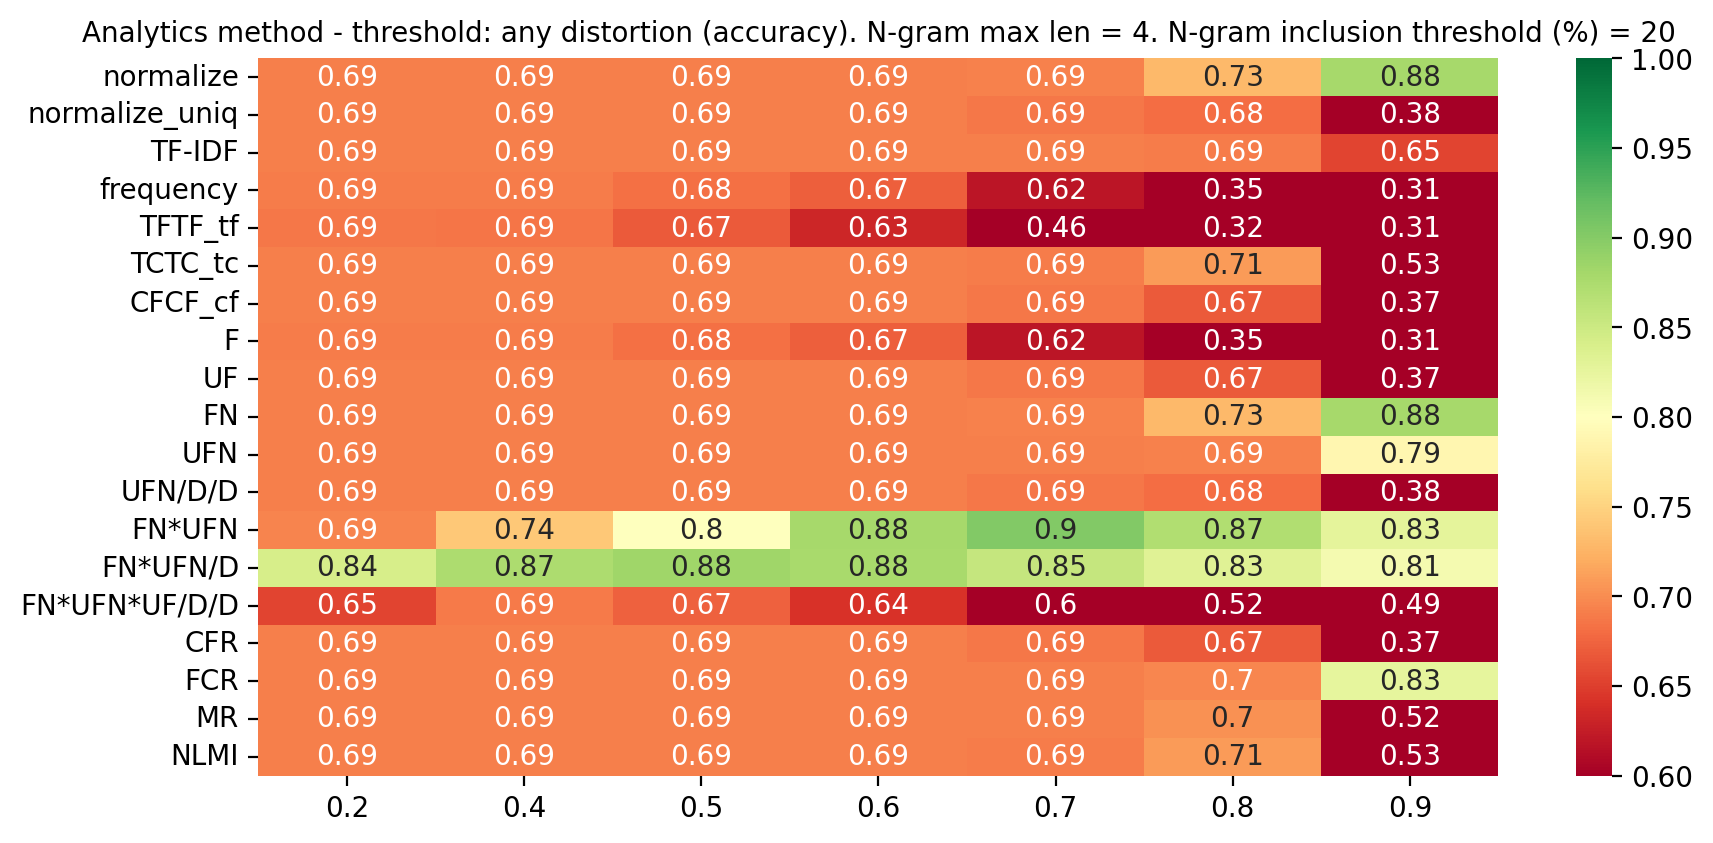

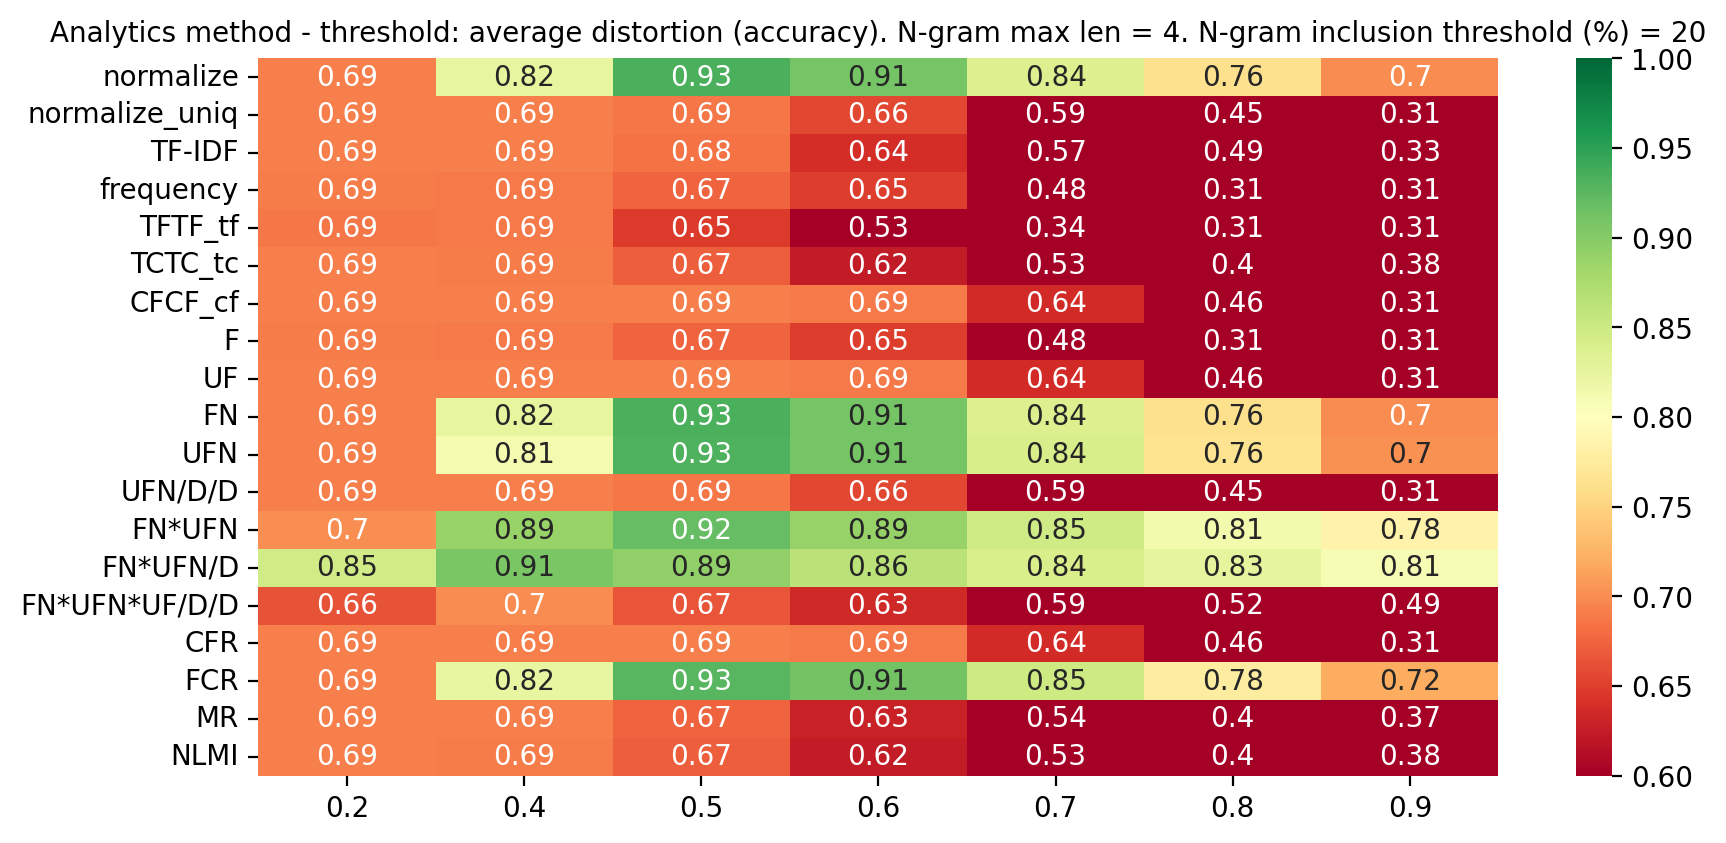

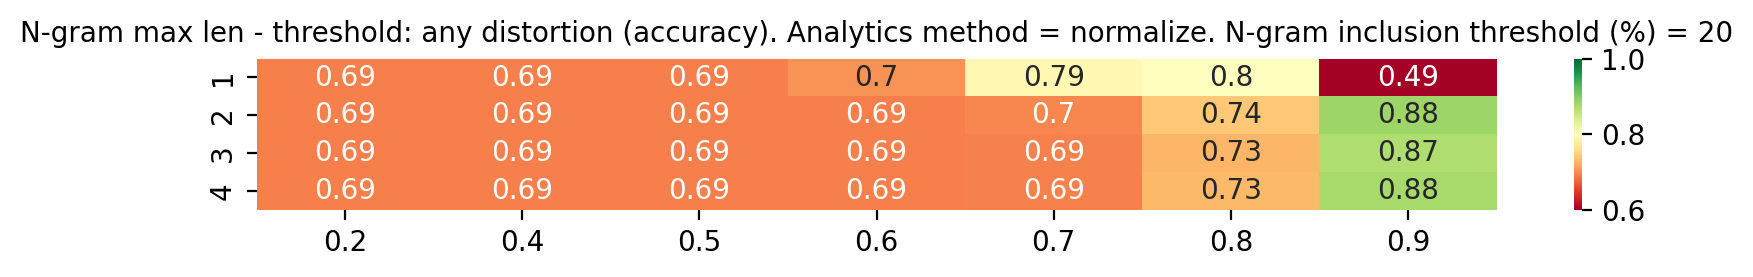

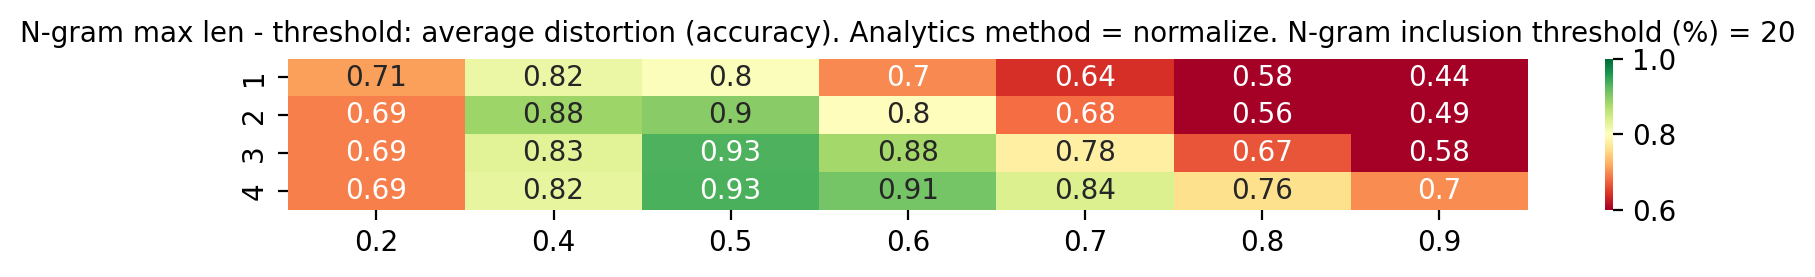

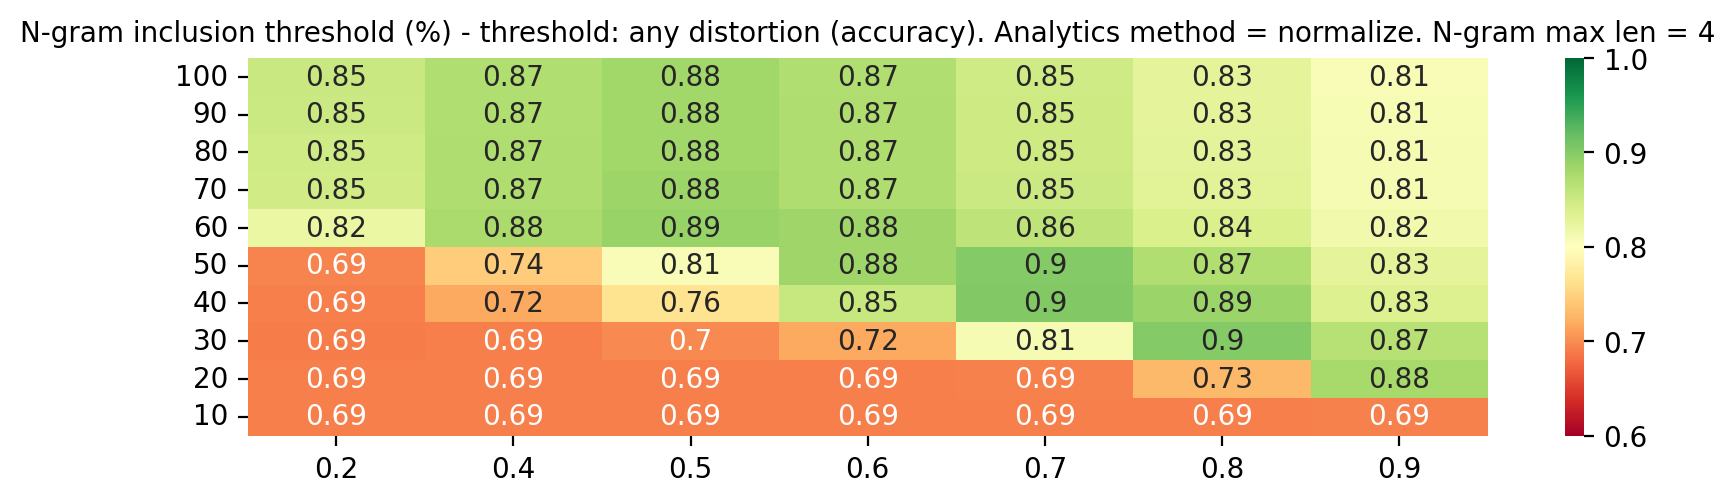

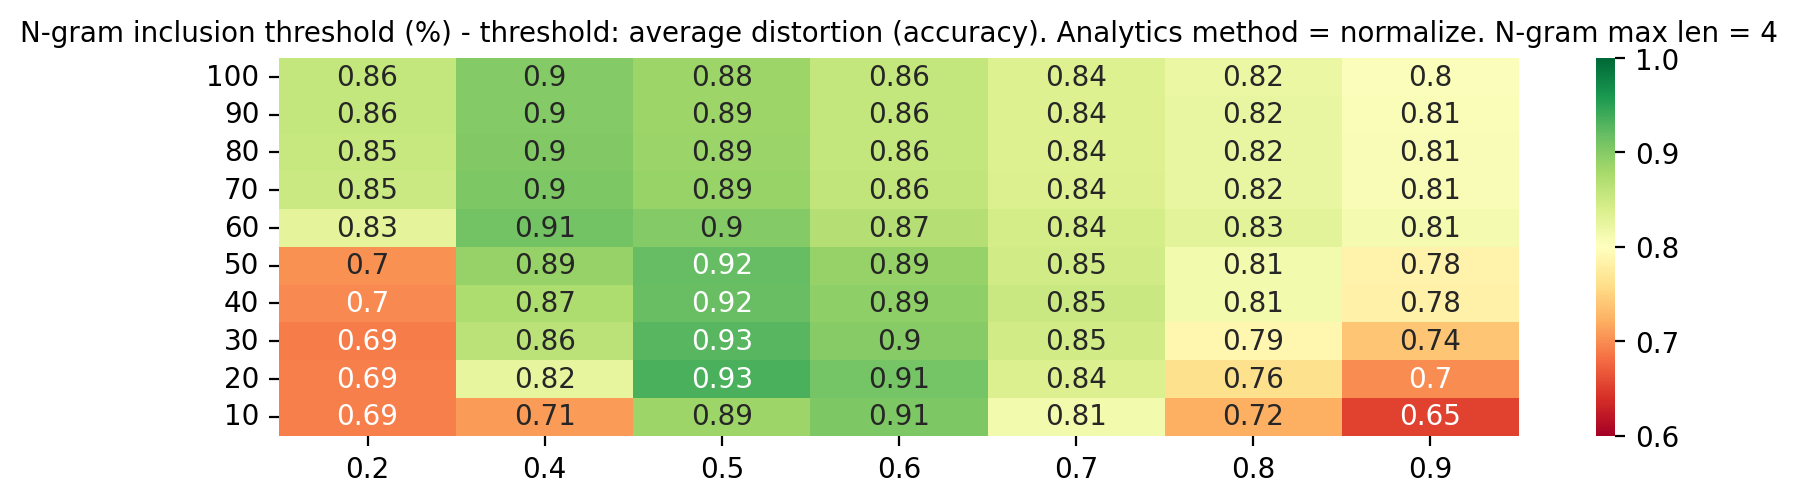

In [10]:
thresholds = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]


# 1) analytics_method - threshold
acc_analytics_threshold_any = np.zeros((len(analytics_methods), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(analytics_methods), len(thresholds)))

for i, analytics_method in enumerate(analytics_methods):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(analytics_method, 4, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(analytics_method, 4, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(analytics_method, 4, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(analytics_methods, thresholds, acc_analytics_threshold_any, 1.0, title = 'Аnalytics method - threshold: any distortion (accuracy). N-gram max len = 4. N-gram inclusion threshold (%) = 20', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)

matrix_plot(analytics_methods, thresholds, acc_analytics_threshold_avg, 1.0, title = 'Аnalytics method - threshold: average distortion (accuracy). N-gram max len = 4. N-gram inclusion threshold (%) = 20', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)



# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset('normalize', ngram_max, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset('normalize', ngram_max, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset('normalize', ngram_max, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0, title = 'N-gram max len - threshold: any distortion (accuracy). Аnalytics method = normalize. N-gram inclusion threshold (%) = 20', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)

matrix_plot(ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0, title = 'N-gram max len - threshold: average distortion (accuracy). Аnalytics method = normalize. N-gram inclusion threshold (%) = 20', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)



# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold_any = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))
acc_ngram_inclusion_threshold_avg = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset('normalize', 4, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset('normalize', 4, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset('normalize', 4, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngram_inclusion_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0, title = 'N-gram inclusion threshold (%) - threshold: any distortion (accuracy). Аnalytics method = normalize. N-gram max len = 4', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)

matrix_plot(ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0, title = 'N-gram inclusion threshold (%) - threshold: average distortion (accuracy). Аnalytics method = normalize. N-gram max len = 4', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 10, dpi = 200, width = 10)

In [11]:
# Best model
for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any, first_split_acc_avg = analyse_dataset('normalize', 4, 20, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any, second_split_acc_avg = analyse_dataset('normalize', 4, 20, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any, third_split_acc_avg = analyse_dataset('normalize', 4, 20, train_df, test_df, 'third_split', 'print_results')
                        


Analytics method: normalize
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8230836490819002
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6998514115898959 0.8231173380035027
		 0.8 0.7434373452204062 0.8440698374473209
		 0.9 0.8841010401188707 0.9187500000000001

		Average distortion (threshold, accuracy, F1 score):
		 0.2 0.6993561168895492 0.8230836490819002
		 0.4 0.8256562654779593 0.8883956880152188
		 0.5 0.9361069836552749 0.9546572934973638
		 0.6 0.9197622585438335 0.9395070948469006
		 0.7 0.846458642892521 0.8768864177918984
		 0.8 0.7711738484398217 0.8047337278106509
		 0.9 0.7102526002971769 0.739188586714222

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.2 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5

In [12]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'2 days, 7:53:16.060777'